In [1]:
import numpy as np
import scipy
import sys
import os
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from lspin.lspin_model import Model
from lspin.utils import DataSet

from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import cm,colors

In [2]:
# if need to use GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

### Linear synthetic data generation

Group 1: $X$ ~ $N(1,0.5)$,  $Y = -2X_1 + X_2 - 0.5X_3$

Group 2: $X$ ~ $N(-1,0.5)$, $Y = -0.5X_3 + X_4 - 2X_5$



In [3]:
np.random.seed(34)

Xs1 = np.random.normal(loc=1,scale=0.5,size=(300,5))
Ys1 = -2*Xs1[:,0]+1*Xs1[:,1]-0.5*Xs1[:,2]

Xs2 = np.random.normal(loc=-1,scale=0.5,size=(300,5))
Ys2 = -0.5*Xs2[:,2]+1*Xs2[:,3]-2*Xs2[:,4]

In [4]:
X_data = np.concatenate((Xs1,Xs2),axis=0)
Y_data = np.concatenate((Ys1.reshape(-1,1),Ys2.reshape(-1,1)),axis=0)

In [5]:
Y_data = Y_data-Y_data.min()
Y_data=Y_data/Y_data.max()

In [6]:
# The ground truth group label of each sample
case_labels = np.concatenate((np.array([1]*300),np.array([2]*300)))

In [7]:
Y_data = np.concatenate((Y_data,case_labels.reshape(-1,1)),axis=1)

In [8]:
# 10% for validation, 10% for test 
X_train,X_remain,yc_train,yc_remain = train_test_split(X_data,Y_data,train_size=0.8,shuffle=True,random_state=34)
X_valid,X_test,yc_valid,yc_test = train_test_split(X_remain,yc_remain,train_size=0.5,shuffle=True,random_state=34)

In [9]:
# Only 10 samples used for training
X_train,_,yc_train,_ = train_test_split(X_train,yc_train,train_size=10,shuffle=True,random_state=34)

In [10]:
print("Sample sizes:")
print(X_train.shape[0],X_valid.shape[0],X_test.shape[0])

Sample sizes:
10 60 60


In [11]:
y_train = yc_train[:,0].reshape(-1,1)
y_valid = yc_valid[:,0].reshape(-1,1)
y_test = yc_test[:,0].reshape(-1,1)

In [12]:
train_label = yc_train[:,1]
valid_label = yc_valid[:,1]
test_label= yc_test[:,1]

In [13]:
Counter(train_label)

Counter({2.0: 6, 1.0: 4})

In [14]:
Counter(valid_label)

Counter({2.0: 29, 1.0: 31})

In [15]:
dataset = DataSet(**{'_data':X_train, '_labels':y_train,
                '_valid_data':X_valid, '_valid_labels':y_valid,
                '_test_data':X_test, '_test_labels':y_test})

In [16]:
# reference ground truth feature matrix (training/test)
ref_feat_mat_train = np.array([[1,1,1,0,0] if label == 1 else [0,0,1,1,1] for label in train_label])
ref_feat_mat_test = np.array([[1,1,1,0,0] if label == 1 else [0,0,1,1,1] for label in test_label])

### LLSPIN

In [17]:
# objective function for optuna hyper-parameter optimization
def llspin_objective(trial):  
    global model
    
    # hyper-parameter specification
    params = {     
        "input_node" : X_train.shape[1],       # input dimension for the prediction network
        "hidden_layers_node" : [100,100,10,1], # number of nodes for each hidden layer of the prediction net
        "output_node" : 1,                     # number of nodes for the output layer of the prediction net
        "feature_selection" : True,            # if using the gating net
        "gating_net_hidden_layers_node": [10], # number of nodes for each hidden layer of the gating net
        "display_step" : 500                   # number of epochs to output info
    }
    params['activation']= 'none' # linear prediction
    params['batch_size']= X_train.shape[0]
    
    # hyper-parameter to optimize: lambda, learning rate, number of epochs
    params['lam'] = trial.suggest_loguniform('lam',1e-3,1e-2)
    params['learning_rate'] = trial.suggest_loguniform('learning_rate', 1e-2, 2e-1)
    num_epoch = trial.suggest_categorical('num_epoch', [2000,5000,10000,15000])

    # specify the model with these parameters and train the model
    model_dir =None
    model = Model(**params)
    train_acces, train_losses, val_acces, val_losses = model.train(trial, dataset, model_dir, num_epoch=num_epoch)

    print("In trial:---------------------")
    val_prediction = model.test(X_valid)[0]
    mse = mean_squared_error(y_valid.reshape(-1),val_prediction.reshape(-1))
    print("validation mse: {}".format(mse))
    
    loss= mse
            
    return loss
        
def callback(study,trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

In [18]:
# optimize the model via Optuna and obtain the best model with smallest validation mse
best_model = None
model = None
study = optuna.create_study(pruner=None)
study.optimize(llspin_objective, n_trials=100, callbacks=[callback])

[I 2021-07-07 16:17:43,635] A new study created in memory with name: no-name-f0870a63-9041-4b96-bdc7-98c0edb21a63








Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



num_samples : 10
Epoch: 500 train loss=0.018438540 valid loss= 0.015716955
train reg_fs: 0.00835622102022171
Epoch: 1000 train loss=0.017322838 valid loss= 0.014847589
train reg_fs: 0.008436045609414577
Epoch: 1500 train loss=0.013249367 valid loss= 0.014965270
train reg_fs: 0.008463893085718155
Epoch: 2000 train loss=0.013308635 valid loss= 0.014766754
train reg_fs: 0.008432308211922646
Epoch: 2500 train loss=0.022618454 valid loss= 0.013934918
train reg_fs: 0.008332078345119953
Epoch: 3000 train loss=0.020706382 valid loss= 0.013845423
train reg_fs: 0.008191204629838467
Epoch: 3500 train

[I 2021-07-07 16:18:56,664] Trial 0 finished with value: 0.0033712446149224717 and parameters: {'lam': 0.009752238715323224, 'learning_rate': 0.037202381457833125, 'num_epoch': 10000}. Best is trial 0 with value: 0.0033712446149224717.


Epoch: 10000 train loss=0.009440141 valid loss= 0.010259671
train reg_fs: 0.006647790782153606
In trial:---------------------
validation mse: 0.0033712446149224717
num_samples : 10
Epoch: 500 train loss=0.010520695 valid loss= 0.007611860
train reg_fs: 0.002909703878685832
Epoch: 1000 train loss=0.007106877 valid loss= 0.005934773
train reg_fs: 0.0026609706692397594
Epoch: 1500 train loss=0.005921209 valid loss= 0.006283443
train reg_fs: 0.002572235418483615
Epoch: 2000 train loss=0.004481396 valid loss= 0.006310771
train reg_fs: 0.0025088870897889137
Epoch: 2500 train loss=0.007562572 valid loss= 0.006246453
train reg_fs: 0.002459912095218897
Epoch: 3000 train loss=0.008592620 valid loss= 0.007075344
train reg_fs: 0.002406116807833314
Epoch: 3500 train loss=0.011139070 valid loss= 0.006633325
train reg_fs: 0.0023615097161382437
Epoch: 4000 train loss=0.008272804 valid loss= 0.006300204
train reg_fs: 0.0023388671688735485
Epoch: 4500 train loss=0.008820269 valid loss= 0.006560373
train

[I 2021-07-07 16:19:31,611] Trial 1 finished with value: 0.003907184721213148 and parameters: {'lam': 0.003638998674347051, 'learning_rate': 0.16825524136744502, 'num_epoch': 5000}. Best is trial 0 with value: 0.0033712446149224717.


Epoch: 5000 train loss=0.004747927 valid loss= 0.006302666
train reg_fs: 0.002323672641068697
In trial:---------------------
validation mse: 0.003907184721213148
num_samples : 10
Epoch: 500 train loss=0.008530087 valid loss= 0.009467341
train reg_fs: 0.0036447152961045504
Epoch: 1000 train loss=0.011600923 valid loss= 0.009464120
train reg_fs: 0.003639901988208294
Epoch: 1500 train loss=0.005960410 valid loss= 0.009498433
train reg_fs: 0.0035575288347899914
Epoch: 2000 train loss=0.007393973 valid loss= 0.007877385
train reg_fs: 0.0034340156707912683
Epoch: 2500 train loss=0.010790829 valid loss= 0.006247856
train reg_fs: 0.0033023098949342966
Epoch: 3000 train loss=0.007266559 valid loss= 0.005844221
train reg_fs: 0.0031709950417280197
Epoch: 3500 train loss=0.005704085 valid loss= 0.005959241
train reg_fs: 0.0030743288807570934
Epoch: 4000 train loss=0.005379365 valid loss= 0.005928935
train reg_fs: 0.0029898195061832666
Epoch: 4500 train loss=0.009836741 valid loss= 0.006265990
trai

[I 2021-07-07 16:21:12,127] Trial 2 finished with value: 0.002232049022448978 and parameters: {'lam': 0.004196013265374776, 'learning_rate': 0.06791179800176345, 'num_epoch': 15000}. Best is trial 2 with value: 0.002232049022448978.


Epoch: 15000 train loss=0.007581359 valid loss= 0.004735713
train reg_fs: 0.0025580190122127533
In trial:---------------------
validation mse: 0.002232049022448978
num_samples : 10
Epoch: 500 train loss=0.007411654 valid loss= 0.008568435
train reg_fs: 0.0028035887517035007
Epoch: 1000 train loss=0.007297157 valid loss= 0.007146023
train reg_fs: 0.0027148278895765543
Epoch: 1500 train loss=0.008437198 valid loss= 0.005534595
train reg_fs: 0.002616224344819784
Epoch: 2000 train loss=0.003570025 valid loss= 0.004601599
train reg_fs: 0.002501643029972911
Epoch: 2500 train loss=0.005905373 valid loss= 0.004676788
train reg_fs: 0.0024286345578730106
Epoch: 3000 train loss=0.003398034 valid loss= 0.004473395
train reg_fs: 0.002380663761869073
Epoch: 3500 train loss=0.003421435 valid loss= 0.004163796
train reg_fs: 0.00234427722170949
Epoch: 4000 train loss=0.004390486 valid loss= 0.004227537
train reg_fs: 0.0023115351796150208
Epoch: 4500 train loss=0.004934733 valid loss= 0.004284174
train 

[I 2021-07-07 16:22:56,414] Trial 3 finished with value: 0.0019119739482977478 and parameters: {'lam': 0.0032441113194873286, 'learning_rate': 0.10286293635225624, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.003879320 valid loss= 0.003846798
train reg_fs: 0.001866811071522534
In trial:---------------------
validation mse: 0.0019119739482977478
num_samples : 10
Epoch: 500 train loss=0.009712338 valid loss= 0.009524901
train reg_fs: 0.001998903462663293
Epoch: 1000 train loss=0.015956739 valid loss= 0.009310525
train reg_fs: 0.002016984159126878
Epoch: 1500 train loss=0.025129378 valid loss= 0.009095894
train reg_fs: 0.0020321011543273926
Epoch: 2000 train loss=0.009460340 valid loss= 0.009065986
train reg_fs: 0.0020441454835236073
Epoch: 2500 train loss=0.023406960 valid loss= 0.008765414
train reg_fs: 0.0020547169260680676
Epoch: 3000 train loss=0.009098036 valid loss= 0.008618538
train reg_fs: 0.0020633444655686617
Epoch: 3500 train loss=0.007043782 valid loss= 0.008037766
train reg_fs: 0.002067859750241041
Epoch: 4000 train loss=0.008630361 valid loss= 0.008360387
train reg_fs: 0.002071092603728175
Epoch: 4500 train loss=0.011324105 valid loss= 0.007886417
train

[I 2021-07-07 16:24:11,616] Trial 4 finished with value: 0.004252717614673269 and parameters: {'lam': 0.0023669480390311826, 'learning_rate': 0.01450002609306495, 'num_epoch': 10000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 10000 train loss=0.006596512 valid loss= 0.006282179
train reg_fs: 0.0019978287164121866
In trial:---------------------
validation mse: 0.004252717614673269
num_samples : 10
Epoch: 500 train loss=0.018378820 valid loss= 0.010700858
train reg_fs: 0.003738424275070429
Epoch: 1000 train loss=0.009357732 valid loss= 0.010640025
train reg_fs: 0.0036262597423046827
Epoch: 1500 train loss=0.013079351 valid loss= 0.008754339
train reg_fs: 0.0034440227318555117
Epoch: 2000 train loss=0.007951460 valid loss= 0.007292965
train reg_fs: 0.0032682018354535103
Epoch: 2500 train loss=0.004485925 valid loss= 0.007058794
train reg_fs: 0.003123880596831441
Epoch: 3000 train loss=0.008699980 valid loss= 0.006939309
train reg_fs: 0.003021953394636512
Epoch: 3500 train loss=0.008847468 valid loss= 0.007215286
train reg_fs: 0.002942192368209362
Epoch: 4000 train loss=0.004839740 valid loss= 0.006686901
train reg_fs: 0.0028763432055711746
Epoch: 4500 train loss=0.006617716 valid loss= 0.006894165
train

[I 2021-07-07 16:25:24,235] Trial 5 finished with value: 0.004094986132649523 and parameters: {'lam': 0.004339033590638614, 'learning_rate': 0.08737207372493697, 'num_epoch': 10000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 10000 train loss=0.007230869 valid loss= 0.006785532
train reg_fs: 0.0025753562804311514
In trial:---------------------
validation mse: 0.004094986132649523
num_samples : 10
Epoch: 500 train loss=0.021309737 valid loss= 0.014178891
train reg_fs: 0.007376149296760559
Epoch: 1000 train loss=0.020777324 valid loss= 0.014100261
train reg_fs: 0.007440496236085892
Epoch: 1500 train loss=0.020182770 valid loss= 0.013333611
train reg_fs: 0.007499519269913435
Epoch: 2000 train loss=0.020171257 valid loss= 0.013150550
train reg_fs: 0.007547160144895315
Epoch: 2500 train loss=0.013978522 valid loss= 0.013085840
train reg_fs: 0.007575965020805597
Epoch: 3000 train loss=0.016699493 valid loss= 0.012766205
train reg_fs: 0.007591468282043934
Epoch: 3500 train loss=0.015936606 valid loss= 0.012515575
train reg_fs: 0.007595913950353861
Epoch: 4000 train loss=0.017040806 valid loss= 0.012539815
train reg_fs: 0.00759788928553462
Epoch: 4500 train loss=0.018361259 valid loss= 0.013109365
train reg_

[I 2021-07-07 16:26:31,894] Trial 6 finished with value: 0.0037036138933585973 and parameters: {'lam': 0.008682087518008606, 'learning_rate': 0.019770993223804628, 'num_epoch': 10000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 10000 train loss=0.010184160 valid loss= 0.010792912
train reg_fs: 0.007020289544016123
In trial:---------------------
validation mse: 0.0037036138933585973
num_samples : 10
Epoch: 500 train loss=0.011083837 valid loss= 0.009001713
train reg_fs: 0.002301086438819766
Epoch: 1000 train loss=0.007652648 valid loss= 0.008427436
train reg_fs: 0.0023106758017092943
Epoch: 1500 train loss=0.017195091 valid loss= 0.007905794
train reg_fs: 0.002274842467159033


[I 2021-07-07 16:26:48,322] Trial 7 finished with value: 0.004588537737262545 and parameters: {'lam': 0.00267618043134795, 'learning_rate': 0.044528615007668484, 'num_epoch': 2000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 2000 train loss=0.004543095 valid loss= 0.006851582
train reg_fs: 0.002230241196230054
In trial:---------------------
validation mse: 0.004588537737262545
num_samples : 10
Epoch: 500 train loss=0.014097854 valid loss= 0.009919522
train reg_fs: 0.004085814114660025
Epoch: 1000 train loss=0.009198876 valid loss= 0.008363171
train reg_fs: 0.004091187845915556
Epoch: 1500 train loss=0.012117873 valid loss= 0.008152429
train reg_fs: 0.004019593819975853
Epoch: 2000 train loss=0.012158480 valid loss= 0.006859762
train reg_fs: 0.00391038041561842
Epoch: 2500 train loss=0.010705290 valid loss= 0.006560984
train reg_fs: 0.003797783050686121
Epoch: 3000 train loss=0.006687652 valid loss= 0.006293603
train reg_fs: 0.003717102576047182
Epoch: 3500 train loss=0.007892331 valid loss= 0.006780007
train reg_fs: 0.0036680251359939575
Epoch: 4000 train loss=0.006611255 valid loss= 0.006649890
train reg_fs: 0.003630788065493107
Epoch: 4500 train loss=0.009481823 valid loss= 0.006406636
train reg_f

[I 2021-07-07 16:27:23,225] Trial 8 finished with value: 0.0028987879553517863 and parameters: {'lam': 0.004766197941502131, 'learning_rate': 0.041662382664848056, 'num_epoch': 5000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 5000 train loss=0.005242334 valid loss= 0.006524335
train reg_fs: 0.0035725217312574387
In trial:---------------------
validation mse: 0.0028987879553517863
num_samples : 10
Epoch: 500 train loss=0.013255943 valid loss= 0.008202463
train reg_fs: 0.0008732426795177162
Epoch: 1000 train loss=0.007151373 valid loss= 0.008501876
train reg_fs: 0.0008882137481123209
Epoch: 1500 train loss=0.009346577 valid loss= 0.007519900
train reg_fs: 0.0008946108282543719
Epoch: 2000 train loss=0.008406430 valid loss= 0.007938777
train reg_fs: 0.0008938300888985395
Epoch: 2500 train loss=0.009064333 valid loss= 0.006385395
train reg_fs: 0.000887042551767081
Epoch: 3000 train loss=0.014901621 valid loss= 0.005543323
train reg_fs: 0.0008764942176640034
Epoch: 3500 train loss=0.008434590 valid loss= 0.005323824
train reg_fs: 0.0008620475418865681
Epoch: 4000 train loss=0.003968457 valid loss= 0.004615495
train reg_fs: 0.0008426580461673439
Epoch: 4500 train loss=0.003784739 valid loss= 0.004036378
tr

[I 2021-07-07 16:29:07,984] Trial 9 finished with value: 0.0024926197304423275 and parameters: {'lam': 0.0010070899241633065, 'learning_rate': 0.04577327699912481, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.001191756 valid loss= 0.003209797
train reg_fs: 0.0007321091252379119
In trial:---------------------
validation mse: 0.0024926197304423275
num_samples : 10
Epoch: 500 train loss=0.005576918 valid loss= 0.005532420
train reg_fs: 0.0013146544806659222
Epoch: 1000 train loss=0.003199724 valid loss= 0.004316331
train reg_fs: 0.0012365110451355577
Epoch: 1500 train loss=0.009360437 valid loss= 0.003822366
train reg_fs: 0.0012047105701640248
Epoch: 2000 train loss=0.004773162 valid loss= 0.003975778
train reg_fs: 0.0011777544859796762
Epoch: 2500 train loss=0.002091066 valid loss= 0.003804302
train reg_fs: 0.0011592262890189886
Epoch: 3000 train loss=0.001747643 valid loss= 0.003834059
train reg_fs: 0.001147650764323771
Epoch: 3500 train loss=0.002018709 valid loss= 0.003961815
train reg_fs: 0.001140520558692515
Epoch: 4000 train loss=0.003948289 valid loss= 0.003883759
train reg_fs: 0.0011345607927069068
Epoch: 4500 train loss=0.001564947 valid loss= 0.003137233
tr

[I 2021-07-07 16:30:52,915] Trial 10 finished with value: 0.002074169586097092 and parameters: {'lam': 0.0015784129728877358, 'learning_rate': 0.19030788914717484, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.004861198 valid loss= 0.003124453
train reg_fs: 0.0011042742989957333
In trial:---------------------
validation mse: 0.002074169586097092
num_samples : 10
Epoch: 500 train loss=0.004941588 valid loss= 0.006374695
train reg_fs: 0.001081109861843288
Epoch: 1000 train loss=0.010940592 valid loss= 0.004899424
train reg_fs: 0.0009956660214811563
Epoch: 1500 train loss=0.001903020 valid loss= 0.003610517
train reg_fs: 0.0009817329701036215
Epoch: 2000 train loss=0.007320695 valid loss= 0.003710801
train reg_fs: 0.0009840986458584666
Epoch: 2500 train loss=0.005103612 valid loss= 0.004228543
train reg_fs: 0.000973123125731945
Epoch: 3000 train loss=0.007033626 valid loss= 0.004114025
train reg_fs: 0.0009395980159752071
Epoch: 3500 train loss=0.002118075 valid loss= 0.004403666
train reg_fs: 0.0008998442790471017
Epoch: 4000 train loss=0.003755659 valid loss= 0.003624070
train reg_fs: 0.0008719840552657843
Epoch: 4500 train loss=0.001486405 valid loss= 0.003537706
tra

[I 2021-07-07 16:32:46,156] Trial 11 finished with value: 0.0022951291477237307 and parameters: {'lam': 0.0012959987028041832, 'learning_rate': 0.1897563308358445, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.005120096 valid loss= 0.003058132
train reg_fs: 0.0007825408247299492
In trial:---------------------
validation mse: 0.0022951291477237307
num_samples : 10
Epoch: 500 train loss=0.009546218 valid loss= 0.007545885
train reg_fs: 0.001477036508731544
Epoch: 1000 train loss=0.002977921 valid loss= 0.008121718
train reg_fs: 0.0014321018243208528
Epoch: 1500 train loss=0.008728495 valid loss= 0.005245520
train reg_fs: 0.0013709957711398602
Epoch: 2000 train loss=0.013623122 valid loss= 0.004531220
train reg_fs: 0.0013186249416321516
Epoch: 2500 train loss=0.009311271 valid loss= 0.004203792
train reg_fs: 0.0012965118512511253
Epoch: 3000 train loss=0.003625361 valid loss= 0.004076757
train reg_fs: 0.0012710427399724722
Epoch: 3500 train loss=0.004473628 valid loss= 0.004248850
train reg_fs: 0.001246376894414425
Epoch: 4000 train loss=0.002035970 valid loss= 0.004114811
train reg_fs: 0.0012241819640621543
Epoch: 4500 train loss=0.010276875 valid loss= 0.003932409
tr

[I 2021-07-07 16:34:41,503] Trial 12 finished with value: 0.0023802806321535264 and parameters: {'lam': 0.0016894996531690242, 'learning_rate': 0.11633008294362888, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.001952269 valid loss= 0.003387487
train reg_fs: 0.001030190964229405
In trial:---------------------
validation mse: 0.0023802806321535264
num_samples : 10
Epoch: 500 train loss=0.010332836 valid loss= 0.007523694
train reg_fs: 0.0016473338473588228
Epoch: 1000 train loss=0.004502397 valid loss= 0.004461618
train reg_fs: 0.0015328872250393033
Epoch: 1500 train loss=0.013547260 valid loss= 0.004037859
train reg_fs: 0.0014508772874251008
Epoch: 2000 train loss=0.006415908 valid loss= 0.004296919
train reg_fs: 0.0013926218962296844
Epoch: 2500 train loss=0.005750671 valid loss= 0.004231054
train reg_fs: 0.0013496280880644917
Epoch: 3000 train loss=0.003090461 valid loss= 0.003518715
train reg_fs: 0.0013163624098524451
Epoch: 3500 train loss=0.005906074 valid loss= 0.003814430
train reg_fs: 0.001290242071263492
Epoch: 4000 train loss=0.002249575 valid loss= 0.003347493
train reg_fs: 0.001271712826564908
Epoch: 4500 train loss=0.002528336 valid loss= 0.003786617
tra

[I 2021-07-07 16:36:35,712] Trial 13 finished with value: 0.002413069690215932 and parameters: {'lam': 0.001919502354009068, 'learning_rate': 0.13550162736147767, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.002765048 valid loss= 0.003548427
train reg_fs: 0.001162726548500359
In trial:---------------------
validation mse: 0.002413069690215932
num_samples : 10
Epoch: 500 train loss=0.010412834 valid loss= 0.008723092
train reg_fs: 0.00451783649623394
Epoch: 1000 train loss=0.007132572 valid loss= 0.006827449
train reg_fs: 0.004040224943310022
Epoch: 1500 train loss=0.007966442 valid loss= 0.006470822
train reg_fs: 0.0038299462758004665
Epoch: 2000 train loss=0.007260585 valid loss= 0.005531370
train reg_fs: 0.003647358389571309
Epoch: 2500 train loss=0.011576775 valid loss= 0.005175321
train reg_fs: 0.0034835690166801214
Epoch: 3000 train loss=0.005028879 valid loss= 0.005109350
train reg_fs: 0.00335579551756382
Epoch: 3500 train loss=0.008768670 valid loss= 0.004946684
train reg_fs: 0.0032534105703234673
Epoch: 4000 train loss=0.004902858 valid loss= 0.004982436
train reg_fs: 0.003166417358443141
Epoch: 4500 train loss=0.006599727 valid loss= 0.005303815
train reg

[I 2021-07-07 16:38:22,255] Trial 14 finished with value: 0.002296355347707305 and parameters: {'lam': 0.0054117921680726395, 'learning_rate': 0.19493924325034886, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.005795862 valid loss= 0.005517680
train reg_fs: 0.0028998826164752245
In trial:---------------------
validation mse: 0.002296355347707305
num_samples : 10
Epoch: 500 train loss=0.016752174 valid loss= 0.010761242
train reg_fs: 0.005523844622075558
Epoch: 1000 train loss=0.011779992 valid loss= 0.008985055
train reg_fs: 0.0053619761019945145
Epoch: 1500 train loss=0.008421335 valid loss= 0.008177083
train reg_fs: 0.005031258333474398


[I 2021-07-07 16:38:37,925] Trial 15 finished with value: 0.0031919081795058024 and parameters: {'lam': 0.0063657810272257165, 'learning_rate': 0.0932285057589025, 'num_epoch': 2000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 2000 train loss=0.011655265 valid loss= 0.008054218
train reg_fs: 0.0048631587997078896
In trial:---------------------
validation mse: 0.0031919081795058024
num_samples : 10
Epoch: 500 train loss=0.012747709 valid loss= 0.008705600
train reg_fs: 0.002595963655039668
Epoch: 1000 train loss=0.010566334 valid loss= 0.008482608
train reg_fs: 0.0026012312155216932
Epoch: 1500 train loss=0.009987625 valid loss= 0.007856146
train reg_fs: 0.002566172741353512
Epoch: 2000 train loss=0.006496692 valid loss= 0.007427849
train reg_fs: 0.0025183078832924366
Epoch: 2500 train loss=0.007401329 valid loss= 0.006601307
train reg_fs: 0.002481306903064251
Epoch: 3000 train loss=0.008031512 valid loss= 0.006146440
train reg_fs: 0.0024539921432733536
Epoch: 3500 train loss=0.003526096 valid loss= 0.005780276
train reg_fs: 0.0024233825970441103
Epoch: 4000 train loss=0.004765121 valid loss= 0.005454064
train reg_fs: 0.0023866049014031887
Epoch: 4500 train loss=0.006540990 valid loss= 0.005024284
trai

[I 2021-07-07 16:40:27,784] Trial 16 finished with value: 0.0022188574004205503 and parameters: {'lam': 0.00300940957228136, 'learning_rate': 0.07016455061423726, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.004023930 valid loss= 0.004273156
train reg_fs: 0.002025045920163393
In trial:---------------------
validation mse: 0.0022188574004205503
num_samples : 10
Epoch: 500 train loss=0.007892313 valid loss= 0.005827641
train reg_fs: 0.0009113551350310445
Epoch: 1000 train loss=0.012622997 valid loss= 0.003426445
train reg_fs: 0.0008494026842527092
Epoch: 1500 train loss=0.002804300 valid loss= 0.002799195
train reg_fs: 0.0008258544257842004
Epoch: 2000 train loss=0.003666538 valid loss= 0.003567406
train reg_fs: 0.0008121322025544941
Epoch: 2500 train loss=0.003871771 valid loss= 0.003317067
train reg_fs: 0.0008004153496585786
Epoch: 3000 train loss=0.001360551 valid loss= 0.002982992
train reg_fs: 0.0007952965679578483
Epoch: 3500 train loss=0.002860926 valid loss= 0.002546645
train reg_fs: 0.0007916894392110407
Epoch: 4000 train loss=0.002460250 valid loss= 0.002908207
train reg_fs: 0.0007903462974354625
Epoch: 4500 train loss=0.001615841 valid loss= 0.002950855
t

[I 2021-07-07 16:42:11,779] Trial 17 finished with value: 0.0019574173873282428 and parameters: {'lam': 0.0010600568155233253, 'learning_rate': 0.13660532207933826, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.003672963 valid loss= 0.002685210
train reg_fs: 0.0007591308676637709
In trial:---------------------
validation mse: 0.0019574173873282428
num_samples : 10
Epoch: 500 train loss=0.007881273 valid loss= 0.008417940
train reg_fs: 0.0009099066955968738
Epoch: 1000 train loss=0.005880639 valid loss= 0.005356520
train reg_fs: 0.0008810619474388659
Epoch: 1500 train loss=0.010058093 valid loss= 0.003289791
train reg_fs: 0.000823174836114049
Epoch: 2000 train loss=0.002303506 valid loss= 0.002944850
train reg_fs: 0.0007968178833834827
Epoch: 2500 train loss=0.001958915 valid loss= 0.003403335
train reg_fs: 0.0007840513135306537
Epoch: 3000 train loss=0.005711653 valid loss= 0.003071256
train reg_fs: 0.0007773612160235643
Epoch: 3500 train loss=0.001463680 valid loss= 0.003094494
train reg_fs: 0.0007733030361123383
Epoch: 4000 train loss=0.002962610 valid loss= 0.002947336
train reg_fs: 0.0007704369490966201
Epoch: 4500 train loss=0.001206211 valid loss= 0.002919983
t

[I 2021-07-07 16:43:59,587] Trial 18 finished with value: 0.002397960006265617 and parameters: {'lam': 0.0010277409037446666, 'learning_rate': 0.13189567183508352, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.001354518 valid loss= 0.003106718
train reg_fs: 0.0007380226161330938
In trial:---------------------
validation mse: 0.002397960006265617
num_samples : 10
Epoch: 500 train loss=0.010394884 valid loss= 0.009547153
train reg_fs: 0.0019395377021282911
Epoch: 1000 train loss=0.012911992 valid loss= 0.009730201
train reg_fs: 0.001960155786946416
Epoch: 1500 train loss=0.005663646 valid loss= 0.008788165
train reg_fs: 0.001968307653442025
Epoch: 2000 train loss=0.007333798 valid loss= 0.008194807
train reg_fs: 0.001966731855645776
Epoch: 2500 train loss=0.014554224 valid loss= 0.008488945
train reg_fs: 0.0019511424470692873
Epoch: 3000 train loss=0.007679864 valid loss= 0.007852846
train reg_fs: 0.0019311095820739865
Epoch: 3500 train loss=0.010124422 valid loss= 0.007354287
train reg_fs: 0.0019060746999457479
Epoch: 4000 train loss=0.007998408 valid loss= 0.007035967
train reg_fs: 0.0018839059630408883
Epoch: 4500 train loss=0.017747425 valid loss= 0.006670534
trai

[I 2021-07-07 16:44:37,594] Trial 19 finished with value: 0.004721167531564698 and parameters: {'lam': 0.002285163700138243, 'learning_rate': 0.028278597233981396, 'num_epoch': 5000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 5000 train loss=0.005730452 valid loss= 0.006629115
train reg_fs: 0.001849964028224349
In trial:---------------------
validation mse: 0.004721167531564698
num_samples : 10
Epoch: 500 train loss=0.018019542 valid loss= 0.012222299
train reg_fs: 0.006173531524837017
Epoch: 1000 train loss=0.011843421 valid loss= 0.012502164
train reg_fs: 0.006260863970965147
Epoch: 1500 train loss=0.010610083 valid loss= 0.012143742
train reg_fs: 0.006249450147151947


[I 2021-07-07 16:44:53,279] Trial 20 finished with value: 0.005847398180294729 and parameters: {'lam': 0.0071369871365200965, 'learning_rate': 0.060629534023094324, 'num_epoch': 2000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 2000 train loss=0.013771764 valid loss= 0.012085645
train reg_fs: 0.006160810589790344
In trial:---------------------
validation mse: 0.005847398180294729
num_samples : 10
Epoch: 500 train loss=0.006200796 valid loss= 0.006782461
train reg_fs: 0.0012189927510917187
Epoch: 1000 train loss=0.004991467 valid loss= 0.006593082
train reg_fs: 0.001220420585013926
Epoch: 1500 train loss=0.005627916 valid loss= 0.006479907
train reg_fs: 0.0012002353323623538
Epoch: 2000 train loss=0.004150445 valid loss= 0.005883846
train reg_fs: 0.0011785412207245827
Epoch: 2500 train loss=0.003213904 valid loss= 0.006111869
train reg_fs: 0.0011552867945283651
Epoch: 3000 train loss=0.002018261 valid loss= 0.005562483
train reg_fs: 0.0011417987989261746
Epoch: 3500 train loss=0.013313800 valid loss= 0.005899913
train reg_fs: 0.001129161100834608
Epoch: 4000 train loss=0.004525078 valid loss= 0.006067776
train reg_fs: 0.001118078944273293
Epoch: 4500 train loss=0.003147169 valid loss= 0.006179418
train 

[I 2021-07-07 16:46:46,041] Trial 21 finished with value: 0.0073885243974804275 and parameters: {'lam': 0.0013687502355616786, 'learning_rate': 0.15927112653311984, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.002632620 valid loss= 0.008399197
train reg_fs: 0.001010204665362835
In trial:---------------------
validation mse: 0.0073885243974804275
num_samples : 10
Epoch: 500 train loss=0.011852589 valid loss= 0.008939554
train reg_fs: 0.0011574322124943137
Epoch: 1000 train loss=0.009822959 valid loss= 0.009593370
train reg_fs: 0.0011779783526435494
Epoch: 1500 train loss=0.014235538 valid loss= 0.008384665
train reg_fs: 0.0011763961520045996
Epoch: 2000 train loss=0.005449486 valid loss= 0.006297727
train reg_fs: 0.0011530687334015965
Epoch: 2500 train loss=0.006821063 valid loss= 0.005472131
train reg_fs: 0.0011051604524254799
Epoch: 3000 train loss=0.007386752 valid loss= 0.004122196
train reg_fs: 0.0010631002951413393
Epoch: 3500 train loss=0.003186460 valid loss= 0.004480056
train reg_fs: 0.0010396880097687244
Epoch: 4000 train loss=0.008121077 valid loss= 0.004677494
train reg_fs: 0.001027559395879507
Epoch: 4500 train loss=0.003975769 valid loss= 0.004593078
tr

[I 2021-07-07 16:48:37,670] Trial 22 finished with value: 0.00269033218997891 and parameters: {'lam': 0.0013150624658620825, 'learning_rate': 0.10367891995389796, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.003660613 valid loss= 0.003640484
train reg_fs: 0.0009506989736109972
In trial:---------------------
validation mse: 0.00269033218997891
num_samples : 10
Epoch: 500 train loss=0.013383875 valid loss= 0.008256570
train reg_fs: 0.0015110127860680223
Epoch: 1000 train loss=0.003981820 valid loss= 0.008197643
train reg_fs: 0.0015067750355228782
Epoch: 1500 train loss=0.004598740 valid loss= 0.008476080
train reg_fs: 0.0014625409385189414
Epoch: 2000 train loss=0.004288622 valid loss= 0.007160685
train reg_fs: 0.001441806904040277
Epoch: 2500 train loss=0.002628624 valid loss= 0.006378389
train reg_fs: 0.0014363168738782406
Epoch: 3000 train loss=0.005035839 valid loss= 0.005961573
train reg_fs: 0.0014253867557272315
Epoch: 3500 train loss=0.005713036 valid loss= 0.006207273
train reg_fs: 0.0014203909086063504
Epoch: 4000 train loss=0.004105903 valid loss= 0.006228741
train reg_fs: 0.0014155255630612373
Epoch: 4500 train loss=0.004243325 valid loss= 0.005953430
tra

[I 2021-07-07 16:50:29,321] Trial 23 finished with value: 0.0064466824668016065 and parameters: {'lam': 0.0016711592475801066, 'learning_rate': 0.19067661022166768, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.002284489 valid loss= 0.007719127
train reg_fs: 0.0012764092534780502
In trial:---------------------
validation mse: 0.0064466824668016065
num_samples : 10
Epoch: 500 train loss=0.015469729 valid loss= 0.005605690
train reg_fs: 0.0009553973795846105
Epoch: 1000 train loss=0.007073063 valid loss= 0.004236475
train reg_fs: 0.0009266643319278955
Epoch: 1500 train loss=0.009125990 valid loss= 0.002928915
train reg_fs: 0.0009028231143020093
Epoch: 2000 train loss=0.005227909 valid loss= 0.002452067
train reg_fs: 0.0008825574186630547
Epoch: 2500 train loss=0.003352774 valid loss= 0.002583522
train reg_fs: 0.0008720760815776885
Epoch: 3000 train loss=0.002322963 valid loss= 0.002706712
train reg_fs: 0.0008645610068924725
Epoch: 3500 train loss=0.002395339 valid loss= 0.002686133
train reg_fs: 0.0008579979185014963
Epoch: 4000 train loss=0.001337433 valid loss= 0.002759193
train reg_fs: 0.0008498432580381632
Epoch: 4500 train loss=0.004509608 valid loss= 0.002727516


[I 2021-07-07 16:52:22,184] Trial 24 finished with value: 0.0024115606331635733 and parameters: {'lam': 0.001107307840141672, 'learning_rate': 0.14225116844453922, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.001637285 valid loss= 0.003170347
train reg_fs: 0.0007663246360607445
In trial:---------------------
validation mse: 0.0024115606331635733
num_samples : 10
Epoch: 500 train loss=0.009420546 valid loss= 0.009040989
train reg_fs: 0.002954656956717372
Epoch: 1000 train loss=0.012287925 valid loss= 0.008927095
train reg_fs: 0.0028977671172469854
Epoch: 1500 train loss=0.008886676 valid loss= 0.007070396
train reg_fs: 0.002731621265411377
Epoch: 2000 train loss=0.006964747 valid loss= 0.005316946
train reg_fs: 0.002586167538538575
Epoch: 2500 train loss=0.009991333 valid loss= 0.005366490
train reg_fs: 0.0024856419768184423
Epoch: 3000 train loss=0.003004946 valid loss= 0.005147526
train reg_fs: 0.0024119503796100616
Epoch: 3500 train loss=0.007988982 valid loss= 0.004939136
train reg_fs: 0.0023534861393272877
Epoch: 4000 train loss=0.002744718 valid loss= 0.004700501
train reg_fs: 0.0023079286329448223
Epoch: 4500 train loss=0.006036821 valid loss= 0.004803377
tra

[I 2021-07-07 16:54:14,369] Trial 25 finished with value: 0.0024355710285127196 and parameters: {'lam': 0.0034124477102156097, 'learning_rate': 0.08441207346761086, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.003387355 valid loss= 0.004492875
train reg_fs: 0.0020955833606421947
In trial:---------------------
validation mse: 0.0024355710285127196
num_samples : 10
Epoch: 500 train loss=0.016279653 valid loss= 0.006646747
train reg_fs: 0.0017706746002659202
Epoch: 1000 train loss=0.009908953 valid loss= 0.005051098
train reg_fs: 0.0016812578542158008
Epoch: 1500 train loss=0.009719472 valid loss= 0.003573696
train reg_fs: 0.0016063569346442819
Epoch: 2000 train loss=0.005940461 valid loss= 0.003834061
train reg_fs: 0.0015723705291748047
Epoch: 2500 train loss=0.004241446 valid loss= 0.003888870
train reg_fs: 0.0015495694242417812
Epoch: 3000 train loss=0.004777881 valid loss= 0.003723329
train reg_fs: 0.0015334408963099122
Epoch: 3500 train loss=0.005441002 valid loss= 0.003797914
train reg_fs: 0.0015225247479975224
Epoch: 4000 train loss=0.002149836 valid loss= 0.004011374
train reg_fs: 0.00151496147736907
Epoch: 4500 train loss=0.002243712 valid loss= 0.003572566
tr

[I 2021-07-07 16:56:08,031] Trial 26 finished with value: 0.002175510377508798 and parameters: {'lam': 0.002022303682827022, 'learning_rate': 0.11826750338849615, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.001840415 valid loss= 0.003545324
train reg_fs: 0.0014322776114568114
In trial:---------------------
validation mse: 0.002175510377508798
num_samples : 10
Epoch: 500 train loss=0.009045027 valid loss= 0.009260069
train reg_fs: 0.0025557486806064844
Epoch: 1000 train loss=0.006814470 valid loss= 0.007634170
train reg_fs: 0.0024086928460747004
Epoch: 1500 train loss=0.003996436 valid loss= 0.006959261
train reg_fs: 0.002350803464651108
Epoch: 2000 train loss=0.006463810 valid loss= 0.006501290
train reg_fs: 0.0023428574204444885
Epoch: 2500 train loss=0.004133494 valid loss= 0.006291104
train reg_fs: 0.002309319796040654
Epoch: 3000 train loss=0.004070926 valid loss= 0.006203867
train reg_fs: 0.002277292078360915
Epoch: 3500 train loss=0.004693797 valid loss= 0.006306817
train reg_fs: 0.0022404897026717663
Epoch: 4000 train loss=0.003836956 valid loss= 0.006674048
train reg_fs: 0.0022095637395977974
Epoch: 4500 train loss=0.005297960 valid loss= 0.006382447
trai

[I 2021-07-07 16:57:51,872] Trial 27 finished with value: 0.006629916570016183 and parameters: {'lam': 0.002908055343116219, 'learning_rate': 0.19494187853650582, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.002808162 valid loss= 0.008539232
train reg_fs: 0.001806535990908742
In trial:---------------------
validation mse: 0.006629916570016183
num_samples : 10
Epoch: 500 train loss=0.007496004 valid loss= 0.007190080
train reg_fs: 0.0014628252247348428
Epoch: 1000 train loss=0.008274710 valid loss= 0.007310632
train reg_fs: 0.001426412258297205
Epoch: 1500 train loss=0.005753425 valid loss= 0.005917922
train reg_fs: 0.0013987967977300286
Epoch: 2000 train loss=0.005233570 valid loss= 0.005368091
train reg_fs: 0.0013885109219700098
Epoch: 2500 train loss=0.005794073 valid loss= 0.005199386
train reg_fs: 0.001377962646074593
Epoch: 3000 train loss=0.002719226 valid loss= 0.004921568
train reg_fs: 0.0013713352382183075
Epoch: 3500 train loss=0.002549948 valid loss= 0.004532565
train reg_fs: 0.0013659456744790077
Epoch: 4000 train loss=0.003301891 valid loss= 0.004869809
train reg_fs: 0.0013523077359423041
Epoch: 4500 train loss=0.004207287 valid loss= 0.005248107
trai

[I 2021-07-07 16:59:43,680] Trial 28 finished with value: 0.004654958742942089 and parameters: {'lam': 0.00164813863760748, 'learning_rate': 0.15360882515078852, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.002576500 valid loss= 0.005848797
train reg_fs: 0.0011898716911673546
In trial:---------------------
validation mse: 0.004654958742942089
num_samples : 10
Epoch: 500 train loss=0.012286318 valid loss= 0.009617325
train reg_fs: 0.0021420051343739033
Epoch: 1000 train loss=0.012253284 valid loss= 0.009968621
train reg_fs: 0.002140364143997431
Epoch: 1500 train loss=0.008251613 valid loss= 0.010068679
train reg_fs: 0.002084453124552965
Epoch: 2000 train loss=0.006620901 valid loss= 0.008318754
train reg_fs: 0.002017282648012042
Epoch: 2500 train loss=0.010022260 valid loss= 0.008054052
train reg_fs: 0.001970752840861678
Epoch: 3000 train loss=0.007987307 valid loss= 0.006321252
train reg_fs: 0.0019279086263850331
Epoch: 3500 train loss=0.003213239 valid loss= 0.005218945
train reg_fs: 0.001887167221866548
Epoch: 4000 train loss=0.004691808 valid loss= 0.004670087
train reg_fs: 0.0018519768491387367
Epoch: 4500 train loss=0.004112240 valid loss= 0.004803026
train 

[I 2021-07-07 17:00:23,031] Trial 29 finished with value: 0.003041673272113167 and parameters: {'lam': 0.0025348116981175435, 'learning_rate': 0.060704091140237906, 'num_epoch': 5000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 5000 train loss=0.009590182 valid loss= 0.004927162
train reg_fs: 0.001822879770770669
In trial:---------------------
validation mse: 0.003041673272113167
num_samples : 10
Epoch: 500 train loss=0.010145595 valid loss= 0.006733996
train reg_fs: 0.0009911494562402368
Epoch: 1000 train loss=0.010170380 valid loss= 0.003494097
train reg_fs: 0.000904356362298131
Epoch: 1500 train loss=0.001589687 valid loss= 0.003099791
train reg_fs: 0.0008628900395706296


[I 2021-07-07 17:00:39,523] Trial 30 finished with value: 0.0019637457660353443 and parameters: {'lam': 0.0011712281433246103, 'learning_rate': 0.10494365352267356, 'num_epoch': 2000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 2000 train loss=0.003376325 valid loss= 0.002814436
train reg_fs: 0.0008340817294083536
In trial:---------------------
validation mse: 0.0019637457660353443
num_samples : 10
Epoch: 500 train loss=0.024245910 valid loss= 0.007710839
train reg_fs: 0.0010423959465697408
Epoch: 1000 train loss=0.010616788 valid loss= 0.007469854
train reg_fs: 0.001041862415149808
Epoch: 1500 train loss=0.011867110 valid loss= 0.006999251
train reg_fs: 0.0010088513372465968


[I 2021-07-07 17:00:55,678] Trial 31 finished with value: 0.004302513953282423 and parameters: {'lam': 0.0011810973786755136, 'learning_rate': 0.10947970550951613, 'num_epoch': 2000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 2000 train loss=0.005457756 valid loss= 0.005299259
train reg_fs: 0.0009785201400518417
In trial:---------------------
validation mse: 0.004302513953282423
num_samples : 10
Epoch: 500 train loss=0.007795386 valid loss= 0.007971732
train reg_fs: 0.0012371422490105033
Epoch: 1000 train loss=0.014059269 valid loss= 0.007585077
train reg_fs: 0.0012273199390619993
Epoch: 1500 train loss=0.007446650 valid loss= 0.005205072
train reg_fs: 0.0011624242179095745


[I 2021-07-07 17:01:11,910] Trial 32 finished with value: 0.003033494833882626 and parameters: {'lam': 0.0014151145989903162, 'learning_rate': 0.0778971224534244, 'num_epoch': 2000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 2000 train loss=0.003756654 valid loss= 0.004156695
train reg_fs: 0.0011134309461340308
In trial:---------------------
validation mse: 0.003033494833882626
num_samples : 10
Epoch: 500 train loss=0.020263184 valid loss= 0.007086319
train reg_fs: 0.0008899177191779017
Epoch: 1000 train loss=0.011111448 valid loss= 0.006835545
train reg_fs: 0.0008932893397286534
Epoch: 1500 train loss=0.005641836 valid loss= 0.007069094
train reg_fs: 0.0008715378935448825


[I 2021-07-07 17:01:28,363] Trial 33 finished with value: 0.0048139973018614755 and parameters: {'lam': 0.0010093692929931054, 'learning_rate': 0.1004676934194616, 'num_epoch': 2000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 2000 train loss=0.013554436 valid loss= 0.005677085
train reg_fs: 0.0008453517802990973
In trial:---------------------
validation mse: 0.0048139973018614755
num_samples : 10
Epoch: 500 train loss=0.018786043 valid loss= 0.009979739
train reg_fs: 0.002975388430058956
Epoch: 1000 train loss=0.016432008 valid loss= 0.009262696
train reg_fs: 0.0029929198790341616
Epoch: 1500 train loss=0.008283346 valid loss= 0.008224092
train reg_fs: 0.0029567533638328314


[I 2021-07-07 17:01:45,252] Trial 34 finished with value: 0.004793817633545167 and parameters: {'lam': 0.0034716033753524785, 'learning_rate': 0.0542710429211111, 'num_epoch': 2000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 2000 train loss=0.005871948 valid loss= 0.007756951
train reg_fs: 0.002896377583965659
In trial:---------------------
validation mse: 0.004793817633545167
num_samples : 10
Epoch: 500 train loss=0.007827248 valid loss= 0.009211878
train reg_fs: 0.0033985814079642296
Epoch: 1000 train loss=0.009244563 valid loss= 0.008648375
train reg_fs: 0.0033106778282672167
Epoch: 1500 train loss=0.011307819 valid loss= 0.006848777
train reg_fs: 0.003252378199249506
Epoch: 2000 train loss=0.005241683 valid loss= 0.006419123
train reg_fs: 0.003181014209985733
Epoch: 2500 train loss=0.006308259 valid loss= 0.006524414
train reg_fs: 0.0031022026669234037
Epoch: 3000 train loss=0.005754887 valid loss= 0.006604324
train reg_fs: 0.003009174717590213
Epoch: 3500 train loss=0.006658580 valid loss= 0.006112549
train reg_fs: 0.0029171768110245466
Epoch: 4000 train loss=0.005817218 valid loss= 0.006267385
train reg_fs: 0.0028510037809610367
Epoch: 4500 train loss=0.004239118 valid loss= 0.006360325
train 

[I 2021-07-07 17:03:00,774] Trial 35 finished with value: 0.0042312384002082485 and parameters: {'lam': 0.003904012471515696, 'learning_rate': 0.15995437360072715, 'num_epoch': 10000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 10000 train loss=0.006151535 valid loss= 0.006702605
train reg_fs: 0.0025289244949817657
In trial:---------------------
validation mse: 0.0042312384002082485
num_samples : 10
Epoch: 500 train loss=0.011417260 valid loss= 0.009221297
train reg_fs: 0.0018131349934265018
Epoch: 1000 train loss=0.012949032 valid loss= 0.008288736
train reg_fs: 0.0018328275764361024
Epoch: 1500 train loss=0.008500876 valid loss= 0.007993957
train reg_fs: 0.0018361939582973719


[I 2021-07-07 17:03:17,566] Trial 36 finished with value: 0.005535882882421653 and parameters: {'lam': 0.002118614290954684, 'learning_rate': 0.03153035113537948, 'num_epoch': 2000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 2000 train loss=0.017388389 valid loss= 0.007376285
train reg_fs: 0.0018274654867127538
In trial:---------------------
validation mse: 0.005535882882421653
num_samples : 10
Epoch: 500 train loss=0.006321870 valid loss= 0.006428045
train reg_fs: 0.001304035889916122
Epoch: 1000 train loss=0.013613960 valid loss= 0.004263521
train reg_fs: 0.0012211337452754378
Epoch: 1500 train loss=0.004812690 valid loss= 0.004255433
train reg_fs: 0.0011824250686913729
Epoch: 2000 train loss=0.001573693 valid loss= 0.004163981
train reg_fs: 0.0011659091105684638
Epoch: 2500 train loss=0.004372786 valid loss= 0.004211146
train reg_fs: 0.0011429155711084604
Epoch: 3000 train loss=0.003749380 valid loss= 0.003767565
train reg_fs: 0.0011174840619787574
Epoch: 3500 train loss=0.001968035 valid loss= 0.003385763
train reg_fs: 0.0010891038691625
Epoch: 4000 train loss=0.003327942 valid loss= 0.003753789
train reg_fs: 0.001062555587850511
Epoch: 4500 train loss=0.002506929 valid loss= 0.003613362
train r

[I 2021-07-07 17:04:33,621] Trial 37 finished with value: 0.002430373631552884 and parameters: {'lam': 0.001518371148215836, 'learning_rate': 0.13042784579295383, 'num_epoch': 10000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 10000 train loss=0.001760719 valid loss= 0.003352673
train reg_fs: 0.0009379431721754372
In trial:---------------------
validation mse: 0.002430373631552884
num_samples : 10
Epoch: 500 train loss=0.018101597 valid loss= 0.006732078
train reg_fs: 0.001000798074528575
Epoch: 1000 train loss=0.007884601 valid loss= 0.004512380
train reg_fs: 0.0009588886750862002
Epoch: 1500 train loss=0.006313150 valid loss= 0.003570361
train reg_fs: 0.000921564525924623
Epoch: 2000 train loss=0.009452056 valid loss= 0.003260442
train reg_fs: 0.0009076205315068364
Epoch: 2500 train loss=0.002998423 valid loss= 0.003548204
train reg_fs: 0.0008973547373898327
Epoch: 3000 train loss=0.010871353 valid loss= 0.003675378
train reg_fs: 0.0008884788840077817
Epoch: 3500 train loss=0.002905758 valid loss= 0.003199016
train reg_fs: 0.0008809822029434144
Epoch: 4000 train loss=0.002212686 valid loss= 0.003420809
train reg_fs: 0.0008748500840738416
Epoch: 4500 train loss=0.011549583 valid loss= 0.003084406
tra

[I 2021-07-07 17:06:27,727] Trial 38 finished with value: 0.0019979400758398276 and parameters: {'lam': 0.001159246544233856, 'learning_rate': 0.08126959062481201, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.001110250 valid loss= 0.002804928
train reg_fs: 0.0008364688837900758
In trial:---------------------
validation mse: 0.0019979400758398276
num_samples : 10
Epoch: 500 train loss=0.008125040 valid loss= 0.007716889
train reg_fs: 0.001015053945593536
Epoch: 1000 train loss=0.012433294 valid loss= 0.007814053
train reg_fs: 0.0010196720249950886
Epoch: 1500 train loss=0.006736852 valid loss= 0.007129299
train reg_fs: 0.0009918541181832552
Epoch: 2000 train loss=0.005717639 valid loss= 0.005033745
train reg_fs: 0.0009615713497623801
Epoch: 2500 train loss=0.006076473 valid loss= 0.003512606
train reg_fs: 0.0009314371854998171
Epoch: 3000 train loss=0.002577344 valid loss= 0.003122080
train reg_fs: 0.0009003712912090123
Epoch: 3500 train loss=0.003879830 valid loss= 0.003848010
train reg_fs: 0.0008816870977170765
Epoch: 4000 train loss=0.006200055 valid loss= 0.003487293
train reg_fs: 0.0008682147017680109
Epoch: 4500 train loss=0.003022976 valid loss= 0.003247585
t

[I 2021-07-07 17:07:05,802] Trial 39 finished with value: 0.0022140070896167472 and parameters: {'lam': 0.0011522842920580624, 'learning_rate': 0.08702532320123463, 'num_epoch': 5000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 5000 train loss=0.001639358 valid loss= 0.003046711
train reg_fs: 0.0008502782438881695
In trial:---------------------
validation mse: 0.0022140070896167472
num_samples : 10
Epoch: 500 train loss=0.025353637 valid loss= 0.010893651
train reg_fs: 0.003784602042287588
Epoch: 1000 train loss=0.019939020 valid loss= 0.009749167
train reg_fs: 0.003757497062906623
Epoch: 1500 train loss=0.012466874 valid loss= 0.007270067
train reg_fs: 0.0036330600269138813
Epoch: 2000 train loss=0.011400321 valid loss= 0.005992848
train reg_fs: 0.003497546073049307
Epoch: 2500 train loss=0.012151484 valid loss= 0.005558033
train reg_fs: 0.0034116089809685946
Epoch: 3000 train loss=0.005787473 valid loss= 0.005587170
train reg_fs: 0.003361279144883156
Epoch: 3500 train loss=0.005255924 valid loss= 0.005365563
train reg_fs: 0.0033189200330525637
Epoch: 4000 train loss=0.004995394 valid loss= 0.005652715
train reg_fs: 0.0032828235998749733
Epoch: 4500 train loss=0.004919808 valid loss= 0.005373313
train

[I 2021-07-07 17:09:01,312] Trial 40 finished with value: 0.0021233592220773903 and parameters: {'lam': 0.004362312823446613, 'learning_rate': 0.07463188195320321, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.007288734 valid loss= 0.005059338
train reg_fs: 0.0030792371835559607
In trial:---------------------
validation mse: 0.0021233592220773903
num_samples : 10
Epoch: 500 train loss=0.016828677 valid loss= 0.008703444
train reg_fs: 0.0010155010968446732
Epoch: 1000 train loss=0.009748944 valid loss= 0.007988364
train reg_fs: 0.0010219999821856618
Epoch: 1500 train loss=0.014362111 valid loss= 0.008372788
train reg_fs: 0.001027726917527616
Epoch: 2000 train loss=0.016929379 valid loss= 0.007830408
train reg_fs: 0.0010327274212613702
Epoch: 2500 train loss=0.010023104 valid loss= 0.007566744
train reg_fs: 0.0010368673829361796
Epoch: 3000 train loss=0.007315549 valid loss= 0.007157423
train reg_fs: 0.0010394146665930748
Epoch: 3500 train loss=0.008553131 valid loss= 0.007541319
train reg_fs: 0.0010408724192529917
Epoch: 4000 train loss=0.008472283 valid loss= 0.007294297
train reg_fs: 0.0010412734700366855
Epoch: 4500 train loss=0.012873764 valid loss= 0.006846572
t

[I 2021-07-07 17:10:54,259] Trial 41 finished with value: 0.0027171837344634546 and parameters: {'lam': 0.0011961658878054718, 'learning_rate': 0.011220213324716226, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.004356679 valid loss= 0.003675017
train reg_fs: 0.0009512398391962051
In trial:---------------------
validation mse: 0.0027171837344634546
num_samples : 10
Epoch: 500 train loss=0.009059818 valid loss= 0.006106894
train reg_fs: 0.0008896039798855782
Epoch: 1000 train loss=0.007740915 valid loss= 0.005419677
train reg_fs: 0.00084185681771487
Epoch: 1500 train loss=0.003734222 valid loss= 0.004499350
train reg_fs: 0.000795910891611129
Epoch: 2000 train loss=0.004873758 valid loss= 0.004243224
train reg_fs: 0.0007733022212050855
Epoch: 2500 train loss=0.011157393 valid loss= 0.004898300
train reg_fs: 0.000755501096136868
Epoch: 3000 train loss=0.002328396 valid loss= 0.004361755
train reg_fs: 0.0007379541639238596
Epoch: 3500 train loss=0.002934149 valid loss= 0.004259409
train reg_fs: 0.0007182802073657513
Epoch: 4000 train loss=0.002044801 valid loss= 0.004136097
train reg_fs: 0.0007041376084089279
Epoch: 4500 train loss=0.004201278 valid loss= 0.004061176
trai

[I 2021-07-07 17:12:49,120] Trial 42 finished with value: 0.0020467052421042956 and parameters: {'lam': 0.001037844827992118, 'learning_rate': 0.11786550391952405, 'num_epoch': 15000}. Best is trial 3 with value: 0.0019119739482977478.


Epoch: 15000 train loss=0.003182341 valid loss= 0.002666804
train reg_fs: 0.0006332789780572057
In trial:---------------------
validation mse: 0.0020467052421042956
num_samples : 10
Epoch: 500 train loss=0.011064606 valid loss= 0.007033543
train reg_fs: 0.0009036316769197583
Epoch: 1000 train loss=0.010999217 valid loss= 0.008142608
train reg_fs: 0.0009132461855188012
Epoch: 1500 train loss=0.002544283 valid loss= 0.005506898
train reg_fs: 0.0008951215422712266
Epoch: 2000 train loss=0.003075307 valid loss= 0.004615648
train reg_fs: 0.0008611482917331159
Epoch: 2500 train loss=0.003365751 valid loss= 0.003321634
train reg_fs: 0.0008270104881376028
Epoch: 3000 train loss=0.005530737 valid loss= 0.002872854
train reg_fs: 0.0008056065998971462
Epoch: 3500 train loss=0.003488756 valid loss= 0.003423112
train reg_fs: 0.0007929048151709139
Epoch: 4000 train loss=0.003062961 valid loss= 0.003050177
train reg_fs: 0.0007848739624023438
Epoch: 4500 train loss=0.003177660 valid loss= 0.002945577


[I 2021-07-07 17:14:40,789] Trial 43 finished with value: 0.001723085639239685 and parameters: {'lam': 0.001025295093628777, 'learning_rate': 0.09591157984689266, 'num_epoch': 15000}. Best is trial 43 with value: 0.001723085639239685.


Epoch: 15000 train loss=0.001613417 valid loss= 0.002467784
train reg_fs: 0.0007542087696492672
In trial:---------------------
validation mse: 0.001723085639239685
num_samples : 10
Epoch: 500 train loss=0.013260603 valid loss= 0.008160269
train reg_fs: 0.0010630650212988257
Epoch: 1000 train loss=0.017161900 valid loss= 0.006821823
train reg_fs: 0.0010743173770606518
Epoch: 1500 train loss=0.016009394 valid loss= 0.007508966
train reg_fs: 0.0010586652206256986
Epoch: 2000 train loss=0.003060853 valid loss= 0.005783869
train reg_fs: 0.001032454427331686
Epoch: 2500 train loss=0.004893013 valid loss= 0.004908983
train reg_fs: 0.001009188825264573
Epoch: 3000 train loss=0.007550775 valid loss= 0.003666770
train reg_fs: 0.0009839863050729036
Epoch: 3500 train loss=0.007393475 valid loss= 0.003583411
train reg_fs: 0.000959605211392045
Epoch: 4000 train loss=0.002224508 valid loss= 0.003236702
train reg_fs: 0.0009414917440153658
Epoch: 4500 train loss=0.002626860 valid loss= 0.003375154
trai

[I 2021-07-07 17:16:33,419] Trial 44 finished with value: 0.0023178988703758782 and parameters: {'lam': 0.0012161537745406308, 'learning_rate': 0.06475827663393825, 'num_epoch': 15000}. Best is trial 43 with value: 0.001723085639239685.


Epoch: 15000 train loss=0.003697706 valid loss= 0.003102598
train reg_fs: 0.0007907297112978995
In trial:---------------------
validation mse: 0.0023178988703758782
num_samples : 10
Epoch: 500 train loss=0.015835833 valid loss= 0.008005773
train reg_fs: 0.0015926450723782182
Epoch: 1000 train loss=0.009531212 valid loss= 0.008699833
train reg_fs: 0.0016216352814808488
Epoch: 1500 train loss=0.015718043 valid loss= 0.007544403
train reg_fs: 0.0016359512228518724
Epoch: 2000 train loss=0.010186793 valid loss= 0.007371034
train reg_fs: 0.00163955835159868
Epoch: 2500 train loss=0.008211687 valid loss= 0.006554466
train reg_fs: 0.0016303907614201307
Epoch: 3000 train loss=0.010295358 valid loss= 0.006695267
train reg_fs: 0.0016181869432330132
Epoch: 3500 train loss=0.005227591 valid loss= 0.005897000
train reg_fs: 0.0016014357097446918
Epoch: 4000 train loss=0.004944705 valid loss= 0.005772611
train reg_fs: 0.0015798246022313833
Epoch: 4500 train loss=0.004562076 valid loss= 0.005717009
tr

[I 2021-07-07 17:17:46,596] Trial 45 finished with value: 0.003012716260950445 and parameters: {'lam': 0.0018367603796572772, 'learning_rate': 0.05011897105867436, 'num_epoch': 10000}. Best is trial 43 with value: 0.001723085639239685.


Epoch: 10000 train loss=0.007026561 valid loss= 0.004387329
train reg_fs: 0.0013687766622751951
In trial:---------------------
validation mse: 0.003012716260950445
num_samples : 10
Epoch: 500 train loss=0.013715152 valid loss= 0.007471397
train reg_fs: 0.0012942020548507571
Epoch: 1000 train loss=0.009775604 valid loss= 0.007617087
train reg_fs: 0.0012835778761655092
Epoch: 1500 train loss=0.007615829 valid loss= 0.007631794
train reg_fs: 0.0012461055302992463
Epoch: 2000 train loss=0.003523996 valid loss= 0.006341166
train reg_fs: 0.0012234323658049107
Epoch: 2500 train loss=0.007169516 valid loss= 0.006094374
train reg_fs: 0.0012090428499504924
Epoch: 3000 train loss=0.004154047 valid loss= 0.005108371
train reg_fs: 0.0012006644392386079
Epoch: 3500 train loss=0.006421434 valid loss= 0.005231558
train reg_fs: 0.0011910664616152644
Epoch: 4000 train loss=0.009734917 valid loss= 0.004773680
train reg_fs: 0.0011780444765463471
Epoch: 4500 train loss=0.004454184 valid loss= 0.004168936
t

[I 2021-07-07 17:19:35,411] Trial 46 finished with value: 0.004194217989067722 and parameters: {'lam': 0.0014919655398465484, 'learning_rate': 0.09530061898904141, 'num_epoch': 15000}. Best is trial 43 with value: 0.001723085639239685.


Epoch: 15000 train loss=0.002266692 valid loss= 0.005188356
train reg_fs: 0.0009636713075451553
In trial:---------------------
validation mse: 0.004194217989067722
num_samples : 10
Epoch: 500 train loss=0.011111177 valid loss= 0.006323041
train reg_fs: 0.0009460024302825332
Epoch: 1000 train loss=0.005533342 valid loss= 0.005672316
train reg_fs: 0.0009205479873344302
Epoch: 1500 train loss=0.014052014 valid loss= 0.003729986
train reg_fs: 0.0008781433571130037
Epoch: 2000 train loss=0.003425569 valid loss= 0.004080697
train reg_fs: 0.0008512609056197107
Epoch: 2500 train loss=0.002699003 valid loss= 0.003684266
train reg_fs: 0.0008374183089472353
Epoch: 3000 train loss=0.002883414 valid loss= 0.003531083
train reg_fs: 0.0008246010402217507
Epoch: 3500 train loss=0.001757243 valid loss= 0.003950144
train reg_fs: 0.0008099093101918697
Epoch: 4000 train loss=0.001972356 valid loss= 0.003853435
train reg_fs: 0.0007947953417897224
Epoch: 4500 train loss=0.002190907 valid loss= 0.003454678
t

[I 2021-07-07 17:21:25,643] Trial 47 finished with value: 0.0021925577443057597 and parameters: {'lam': 0.0010984414216803028, 'learning_rate': 0.08108928739800478, 'num_epoch': 15000}. Best is trial 43 with value: 0.001723085639239685.


Epoch: 15000 train loss=0.002221260 valid loss= 0.002864717
train reg_fs: 0.0006814424996264279
In trial:---------------------
validation mse: 0.0021925577443057597
num_samples : 10
Epoch: 500 train loss=0.012621040 valid loss= 0.008273821
train reg_fs: 0.0024415585212409496
Epoch: 1000 train loss=0.009922260 valid loss= 0.008033072
train reg_fs: 0.0024623582139611244
Epoch: 1500 train loss=0.008610829 valid loss= 0.006543682
train reg_fs: 0.0024396174121648073


[I 2021-07-07 17:21:39,999] Trial 48 finished with value: 0.0044812487582021835 and parameters: {'lam': 0.00275397811201166, 'learning_rate': 0.11801902054384042, 'num_epoch': 2000}. Best is trial 43 with value: 0.001723085639239685.


Epoch: 2000 train loss=0.004395868 valid loss= 0.006900598
train reg_fs: 0.002404651837423444
In trial:---------------------
validation mse: 0.0044812487582021835
num_samples : 10
Epoch: 500 train loss=0.012930850 valid loss= 0.009201839
train reg_fs: 0.0043775662779808044
Epoch: 1000 train loss=0.014710696 valid loss= 0.008828107
train reg_fs: 0.004235353320837021
Epoch: 1500 train loss=0.010910696 valid loss= 0.006581491
train reg_fs: 0.004017066676169634
Epoch: 2000 train loss=0.009026833 valid loss= 0.006331631
train reg_fs: 0.0038845553062856197
Epoch: 2500 train loss=0.010545660 valid loss= 0.006153146
train reg_fs: 0.003813608782365918
Epoch: 3000 train loss=0.010854440 valid loss= 0.006338631
train reg_fs: 0.0037699833046644926
Epoch: 3500 train loss=0.006550487 valid loss= 0.006679676
train reg_fs: 0.0037337124813348055
Epoch: 4000 train loss=0.005854597 valid loss= 0.006681055
train reg_fs: 0.00369240646250546
Epoch: 4500 train loss=0.006072040 valid loss= 0.006506461
train r

[I 2021-07-07 17:23:30,048] Trial 49 finished with value: 0.0032137442841946367 and parameters: {'lam': 0.00507337541764997, 'learning_rate': 0.0950580315875701, 'num_epoch': 15000}. Best is trial 43 with value: 0.001723085639239685.


Epoch: 15000 train loss=0.004111354 valid loss= 0.006502925
train reg_fs: 0.0031926799565553665
In trial:---------------------
validation mse: 0.0032137442841946367
num_samples : 10
Epoch: 500 train loss=0.008918284 valid loss= 0.005548774
train reg_fs: 0.0008647497743368149
Epoch: 1000 train loss=0.006307492 valid loss= 0.004450226
train reg_fs: 0.0008501444244757295
Epoch: 1500 train loss=0.003096544 valid loss= 0.004315443
train reg_fs: 0.000815195613540709
Epoch: 2000 train loss=0.003068485 valid loss= 0.003805289
train reg_fs: 0.0007882242789492011
Epoch: 2500 train loss=0.005528885 valid loss= 0.003546641
train reg_fs: 0.0007736098486930132
Epoch: 3000 train loss=0.002148121 valid loss= 0.003467384
train reg_fs: 0.0007619924726895988
Epoch: 3500 train loss=0.004094348 valid loss= 0.003557678
train reg_fs: 0.0007510537980124354
Epoch: 4000 train loss=0.002912216 valid loss= 0.003267714
train reg_fs: 0.0007408791570924222
Epoch: 4500 train loss=0.001599431 valid loss= 0.003090749
t

[I 2021-07-07 17:25:08,672] Trial 50 finished with value: 0.002637456246224324 and parameters: {'lam': 0.0010002070438323268, 'learning_rate': 0.07208660992183004, 'num_epoch': 15000}. Best is trial 43 with value: 0.001723085639239685.


Epoch: 15000 train loss=0.001802486 valid loss= 0.003259127
train reg_fs: 0.0006294827326200902
In trial:---------------------
validation mse: 0.002637456246224324
num_samples : 10
Epoch: 500 train loss=0.012550692 valid loss= 0.007890301
train reg_fs: 0.0009380635456182063
Epoch: 1000 train loss=0.005890850 valid loss= 0.008117921
train reg_fs: 0.0009499642765149474
Epoch: 1500 train loss=0.009357761 valid loss= 0.007155944
train reg_fs: 0.0009381443960592151
Epoch: 2000 train loss=0.007242325 valid loss= 0.006109572
train reg_fs: 0.000915739219635725
Epoch: 2500 train loss=0.005272841 valid loss= 0.005803443
train reg_fs: 0.0008999189594760537
Epoch: 3000 train loss=0.002927808 valid loss= 0.005817011
train reg_fs: 0.0008919640094973147
Epoch: 3500 train loss=0.001733248 valid loss= 0.005191167
train reg_fs: 0.000888208276592195
Epoch: 4000 train loss=0.003989981 valid loss= 0.004817706
train reg_fs: 0.0008883961127139628
Epoch: 4500 train loss=0.003057578 valid loss= 0.004727179
tra

[I 2021-07-07 17:26:44,121] Trial 51 finished with value: 0.006161720182905103 and parameters: {'lam': 0.0010612427880881494, 'learning_rate': 0.1218317429074103, 'num_epoch': 15000}. Best is trial 43 with value: 0.001723085639239685.


Epoch: 15000 train loss=0.003454675 valid loss= 0.007018254
train reg_fs: 0.0008406066917814314
In trial:---------------------
validation mse: 0.006161720182905103
num_samples : 10
Epoch: 500 train loss=0.006324640 valid loss= 0.005191664
train reg_fs: 0.001094815437681973
Epoch: 1000 train loss=0.002457028 valid loss= 0.003196653
train reg_fs: 0.001017305301502347
Epoch: 1500 train loss=0.001254077 valid loss= 0.003263639
train reg_fs: 0.0009897119598463178
Epoch: 2000 train loss=0.004463192 valid loss= 0.002821974
train reg_fs: 0.0009741854155436158
Epoch: 2500 train loss=0.001978706 valid loss= 0.002995444
train reg_fs: 0.00096366205252707
Epoch: 3000 train loss=0.002503518 valid loss= 0.003282242
train reg_fs: 0.0009573647403158247
Epoch: 3500 train loss=0.001165520 valid loss= 0.002913462
train reg_fs: 0.0009536095312796533
Epoch: 4000 train loss=0.002486203 valid loss= 0.002609610
train reg_fs: 0.0009513293043710291
Epoch: 4500 train loss=0.002960461 valid loss= 0.002905177
train

[I 2021-07-07 17:28:20,662] Trial 52 finished with value: 0.0004479713151502902 and parameters: {'lam': 0.0012749254225682, 'learning_rate': 0.14365154241426814, 'num_epoch': 15000}. Best is trial 52 with value: 0.0004479713151502902.


Epoch: 15000 train loss=0.001353198 valid loss= 0.001313634
train reg_fs: 0.0008651551324874163
In trial:---------------------
validation mse: 0.0004479713151502902
num_samples : 10
Epoch: 500 train loss=0.008794841 valid loss= 0.007030687
train reg_fs: 0.0011042042169719934
Epoch: 1000 train loss=0.013664585 valid loss= 0.006150428
train reg_fs: 0.0010740035213530064
Epoch: 1500 train loss=0.004705765 valid loss= 0.004547217
train reg_fs: 0.0010206984588876367
Epoch: 2000 train loss=0.002981705 valid loss= 0.004022726
train reg_fs: 0.0009829065529629588
Epoch: 2500 train loss=0.004072207 valid loss= 0.003822467
train reg_fs: 0.0009552543051540852
Epoch: 3000 train loss=0.003494243 valid loss= 0.004472232
train reg_fs: 0.0009357493836432695
Epoch: 3500 train loss=0.003601147 valid loss= 0.004382988
train reg_fs: 0.0009231362491846085
Epoch: 4000 train loss=0.005154479 valid loss= 0.004506035
train reg_fs: 0.0009117271401919425
Epoch: 4500 train loss=0.006912685 valid loss= 0.004544257


[I 2021-07-07 17:29:55,893] Trial 53 finished with value: 0.004052427421152404 and parameters: {'lam': 0.0012571913841931295, 'learning_rate': 0.148579284233222, 'num_epoch': 15000}. Best is trial 52 with value: 0.0004479713151502902.


Epoch: 15000 train loss=0.002870364 valid loss= 0.004898880
train reg_fs: 0.0008116501267068088
In trial:---------------------
validation mse: 0.004052427421152404
num_samples : 10
Epoch: 500 train loss=0.014598181 valid loss= 0.006445351
train reg_fs: 0.0026299788150936365
Epoch: 1000 train loss=0.007667793 valid loss= 0.005427260
train reg_fs: 0.0024565753992646933
Epoch: 1500 train loss=0.002550491 valid loss= 0.005521519
train reg_fs: 0.0023719724267721176
Epoch: 2000 train loss=0.004872562 valid loss= 0.004583466
train reg_fs: 0.0023209936916828156
Epoch: 2500 train loss=0.004823961 valid loss= 0.005222524
train reg_fs: 0.0022822802420705557
Epoch: 3000 train loss=0.004228760 valid loss= 0.004558093
train reg_fs: 0.00226051383651793
Epoch: 3500 train loss=0.006154554 valid loss= 0.004276718
train reg_fs: 0.0022453300189226866
Epoch: 4000 train loss=0.003123625 valid loss= 0.004167875
train reg_fs: 0.002219902817159891
Epoch: 4500 train loss=0.003933806 valid loss= 0.003987181
trai

[I 2021-07-07 17:31:30,740] Trial 54 finished with value: 0.0021082446265529207 and parameters: {'lam': 0.0031828768874612003, 'learning_rate': 0.16851452666498185, 'num_epoch': 15000}. Best is trial 52 with value: 0.0004479713151502902.


Epoch: 15000 train loss=0.002545447 valid loss= 0.003970179
train reg_fs: 0.0019134385511279106
In trial:---------------------
validation mse: 0.0021082446265529207
num_samples : 10
Epoch: 500 train loss=0.017847493 valid loss= 0.009151521
train reg_fs: 0.001201093546114862
Epoch: 1000 train loss=0.005580411 valid loss= 0.007547425
train reg_fs: 0.001148149953223765
Epoch: 1500 train loss=0.003428110 valid loss= 0.006780877
train reg_fs: 0.0011146372416988015
Epoch: 2000 train loss=0.006287749 valid loss= 0.005679726
train reg_fs: 0.0011033089831471443
Epoch: 2500 train loss=0.002856551 valid loss= 0.005259663
train reg_fs: 0.0010859754402190447
Epoch: 3000 train loss=0.003107882 valid loss= 0.004118113
train reg_fs: 0.0010639714309945703
Epoch: 3500 train loss=0.003029233 valid loss= 0.004412265
train reg_fs: 0.0010350680677220225
Epoch: 4000 train loss=0.005592790 valid loss= 0.004176992
train reg_fs: 0.0010117660276591778
Epoch: 4500 train loss=0.001695701 valid loss= 0.004026045
tr

[I 2021-07-07 17:33:07,461] Trial 55 finished with value: 0.003042795898380956 and parameters: {'lam': 0.0013650121224895889, 'learning_rate': 0.1717577824306553, 'num_epoch': 15000}. Best is trial 52 with value: 0.0004479713151502902.


Epoch: 15000 train loss=0.001597900 valid loss= 0.003945473
train reg_fs: 0.0009198372717946768
In trial:---------------------
validation mse: 0.003042795898380956
num_samples : 10
Epoch: 500 train loss=0.022862017 valid loss= 0.008832574
train reg_fs: 0.0011439351364970207
Epoch: 1000 train loss=0.004633224 valid loss= 0.008376240
train reg_fs: 0.0011540326522663236
Epoch: 1500 train loss=0.013029359 valid loss= 0.006753944
train reg_fs: 0.0011357292532920837
Epoch: 2000 train loss=0.008102205 valid loss= 0.005720501
train reg_fs: 0.0010964790126308799
Epoch: 2500 train loss=0.003355396 valid loss= 0.004935850
train reg_fs: 0.0010539194336161017
Epoch: 3000 train loss=0.004377290 valid loss= 0.003656029
train reg_fs: 0.0010176505893468857
Epoch: 3500 train loss=0.003862029 valid loss= 0.003785043
train reg_fs: 0.0009910068474709988
Epoch: 4000 train loss=0.003977851 valid loss= 0.003823437
train reg_fs: 0.0009737653890624642
Epoch: 4500 train loss=0.002580680 valid loss= 0.003868913
t

[I 2021-07-07 17:33:41,361] Trial 56 finished with value: 0.0032675370828452806 and parameters: {'lam': 0.0012877587546825788, 'learning_rate': 0.10438176792834952, 'num_epoch': 5000}. Best is trial 52 with value: 0.0004479713151502902.


Epoch: 5000 train loss=0.003866276 valid loss= 0.004202264
train reg_fs: 0.0009490041411481798
In trial:---------------------
validation mse: 0.0032675370828452806
num_samples : 10
Epoch: 500 train loss=0.014255867 valid loss= 0.007327354
train reg_fs: 0.0015947811771184206
Epoch: 1000 train loss=0.006470286 valid loss= 0.006681393
train reg_fs: 0.001549446489661932
Epoch: 1500 train loss=0.003404870 valid loss= 0.004459262
train reg_fs: 0.0015045716427266598
Epoch: 2000 train loss=0.004436884 valid loss= 0.004612260
train reg_fs: 0.0014552850043401122
Epoch: 2500 train loss=0.004239349 valid loss= 0.004056696
train reg_fs: 0.0014343808870762587
Epoch: 3000 train loss=0.002753151 valid loss= 0.004705151
train reg_fs: 0.0014237924478948116
Epoch: 3500 train loss=0.004896834 valid loss= 0.004441453
train reg_fs: 0.001409347401931882
Epoch: 4000 train loss=0.002759396 valid loss= 0.004260948
train reg_fs: 0.0013910738052800298
Epoch: 4500 train loss=0.009915503 valid loss= 0.003821074
tra

[I 2021-07-07 17:35:21,460] Trial 57 finished with value: 0.0024202102002830756 and parameters: {'lam': 0.0018311310403934405, 'learning_rate': 0.13834511663541105, 'num_epoch': 15000}. Best is trial 52 with value: 0.0004479713151502902.


Epoch: 15000 train loss=0.002352571 valid loss= 0.003622690
train reg_fs: 0.0012428973568603396
In trial:---------------------
validation mse: 0.0024202102002830756
num_samples : 10
Epoch: 500 train loss=0.022602819 valid loss= 0.010846630
train reg_fs: 0.0033495170064270496
Epoch: 1000 train loss=0.009310639 valid loss= 0.011635570
train reg_fs: 0.0033959802240133286
Epoch: 1500 train loss=0.010268489 valid loss= 0.012219052
train reg_fs: 0.0033883070573210716
Epoch: 2000 train loss=0.007784364 valid loss= 0.011618878
train reg_fs: 0.0033189598470926285
Epoch: 2500 train loss=0.005872739 valid loss= 0.010150148
train reg_fs: 0.00324205681681633
Epoch: 3000 train loss=0.008445860 valid loss= 0.009287674
train reg_fs: 0.003187251277267933
Epoch: 3500 train loss=0.007762290 valid loss= 0.009197694
train reg_fs: 0.003151204902678728
Epoch: 4000 train loss=0.008341774 valid loss= 0.008691704
train reg_fs: 0.0031255336944013834
Epoch: 4500 train loss=0.004387011 valid loss= 0.008595386
trai

[I 2021-07-07 17:37:00,734] Trial 58 finished with value: 0.00505657011582325 and parameters: {'lam': 0.0038363930263235185, 'learning_rate': 0.08958440985888318, 'num_epoch': 15000}. Best is trial 52 with value: 0.0004479713151502902.


Epoch: 15000 train loss=0.006239026 valid loss= 0.007805386
train reg_fs: 0.0027316282503306866
In trial:---------------------
validation mse: 0.00505657011582325
num_samples : 10
Epoch: 500 train loss=0.011818959 valid loss= 0.007708380
train reg_fs: 0.0012558993184939027
Epoch: 1000 train loss=0.010758054 valid loss= 0.008214249
train reg_fs: 0.0012535612331703305
Epoch: 1500 train loss=0.004982856 valid loss= 0.007719641
train reg_fs: 0.0012235502945259213


[I 2021-07-07 17:37:15,398] Trial 59 finished with value: 0.005592057807751365 and parameters: {'lam': 0.0014346642309730983, 'learning_rate': 0.10686279610366928, 'num_epoch': 2000}. Best is trial 52 with value: 0.0004479713151502902.


Epoch: 2000 train loss=0.005906273 valid loss= 0.006837156
train reg_fs: 0.0012120036408305168
In trial:---------------------
validation mse: 0.005592057807751365
num_samples : 10
Epoch: 500 train loss=0.008579886 valid loss= 0.005929688
train reg_fs: 0.0009599208133295178
Epoch: 1000 train loss=0.010039265 valid loss= 0.004085103
train reg_fs: 0.0008908321615308523
Epoch: 1500 train loss=0.006633197 valid loss= 0.003534896
train reg_fs: 0.0008624815382063389
Epoch: 2000 train loss=0.001487081 valid loss= 0.003483048
train reg_fs: 0.0008472643094137311
Epoch: 2500 train loss=0.001968050 valid loss= 0.003360557
train reg_fs: 0.0008313077269122005
Epoch: 3000 train loss=0.003953223 valid loss= 0.003247639
train reg_fs: 0.0008190685184672475
Epoch: 3500 train loss=0.001877960 valid loss= 0.003087383
train reg_fs: 0.0008086998132057488
Epoch: 4000 train loss=0.004756636 valid loss= 0.003207600
train reg_fs: 0.0007985351257957518
Epoch: 4500 train loss=0.001396024 valid loss= 0.003121422
tr

[I 2021-07-07 17:38:56,632] Trial 60 finished with value: 0.0024506438564275927 and parameters: {'lam': 0.0011120085742816392, 'learning_rate': 0.12975479111046914, 'num_epoch': 15000}. Best is trial 52 with value: 0.0004479713151502902.


Epoch: 15000 train loss=0.004982404 valid loss= 0.003116084
train reg_fs: 0.0006793694337829947
In trial:---------------------
validation mse: 0.0024506438564275927
num_samples : 10
Epoch: 500 train loss=0.004204234 valid loss= 0.007408222
train reg_fs: 0.0008606216288171709
Epoch: 1000 train loss=0.005879309 valid loss= 0.004037298
train reg_fs: 0.0008265014039352536
Epoch: 1500 train loss=0.005438773 valid loss= 0.003052586
train reg_fs: 0.000798392400611192
Epoch: 2000 train loss=0.003886301 valid loss= 0.003651814
train reg_fs: 0.0007804037886671722
Epoch: 2500 train loss=0.002676220 valid loss= 0.003481374
train reg_fs: 0.00076646963134408
Epoch: 3000 train loss=0.001949562 valid loss= 0.003886625
train reg_fs: 0.000755575078073889
Epoch: 3500 train loss=0.001252564 valid loss= 0.003527611
train reg_fs: 0.0007481517386622727
Epoch: 4000 train loss=0.002510862 valid loss= 0.003127816
train reg_fs: 0.0007419664761982858
Epoch: 4500 train loss=0.001635852 valid loss= 0.003357311
trai

[I 2021-07-07 17:40:34,689] Trial 61 finished with value: 0.0018862940674741258 and parameters: {'lam': 0.0010131150928934516, 'learning_rate': 0.1183571940280598, 'num_epoch': 15000}. Best is trial 52 with value: 0.0004479713151502902.


Epoch: 15000 train loss=0.003515311 valid loss= 0.002568660
train reg_fs: 0.0007117302156984806
In trial:---------------------
validation mse: 0.0018862940674741258
num_samples : 10
Epoch: 500 train loss=0.011451950 valid loss= 0.006519410
train reg_fs: 0.0008845514385029674
Epoch: 1000 train loss=0.009236456 valid loss= 0.004859136
train reg_fs: 0.0008473971392959356
Epoch: 1500 train loss=0.007382000 valid loss= 0.002978417
train reg_fs: 0.0008059387328103185
Epoch: 2000 train loss=0.005855658 valid loss= 0.002662785
train reg_fs: 0.0007868887041695416
Epoch: 2500 train loss=0.005960721 valid loss= 0.002610391
train reg_fs: 0.0007743475143797696
Epoch: 3000 train loss=0.005477043 valid loss= 0.003812082
train reg_fs: 0.0007647883612662554
Epoch: 3500 train loss=0.001273798 valid loss= 0.003081280
train reg_fs: 0.0007557364297099411
Epoch: 4000 train loss=0.002669717 valid loss= 0.003232247
train reg_fs: 0.0007469532429240644
Epoch: 4500 train loss=0.001428190 valid loss= 0.002920938


[I 2021-07-07 17:42:14,018] Trial 62 finished with value: 0.0027673033678123904 and parameters: {'lam': 0.0010191513303361185, 'learning_rate': 0.11292153903128034, 'num_epoch': 15000}. Best is trial 52 with value: 0.0004479713151502902.


Epoch: 15000 train loss=0.005317113 valid loss= 0.003403509
train reg_fs: 0.0006429373752325773
In trial:---------------------
validation mse: 0.0027673033678123904
num_samples : 10
Epoch: 500 train loss=0.002963026 valid loss= 0.006617148
train reg_fs: 0.0010095465695485473
Epoch: 1000 train loss=0.007867098 valid loss= 0.005514849
train reg_fs: 0.0009516977006569505
Epoch: 1500 train loss=0.002384124 valid loss= 0.003966843
train reg_fs: 0.0008842407260090113
Epoch: 2000 train loss=0.002356196 valid loss= 0.003584986
train reg_fs: 0.0008577736443839967
Epoch: 2500 train loss=0.001978703 valid loss= 0.003193694
train reg_fs: 0.0008456406649202108
Epoch: 3000 train loss=0.003834464 valid loss= 0.003185356
train reg_fs: 0.0008409271249547601
Epoch: 3500 train loss=0.002083371 valid loss= 0.003020062
train reg_fs: 0.0008341495413333178
Epoch: 4000 train loss=0.003703319 valid loss= 0.003027652
train reg_fs: 0.0008270346443168819
Epoch: 4500 train loss=0.003356114 valid loss= 0.003394236


[I 2021-07-07 17:43:53,355] Trial 63 finished with value: 0.002525780479196181 and parameters: {'lam': 0.0011413536362712441, 'learning_rate': 0.1731099420181286, 'num_epoch': 15000}. Best is trial 52 with value: 0.0004479713151502902.


Epoch: 15000 train loss=0.002058736 valid loss= 0.003280496
train reg_fs: 0.0007802906329743564
In trial:---------------------
validation mse: 0.002525780479196181
num_samples : 10
Epoch: 500 train loss=0.019906815 valid loss= 0.008576143
train reg_fs: 0.0011088547762483358
Epoch: 1000 train loss=0.011126397 valid loss= 0.004030507
train reg_fs: 0.0010395388817414641
Epoch: 1500 train loss=0.001709298 valid loss= 0.003423055
train reg_fs: 0.0010024202056229115
Epoch: 2000 train loss=0.008391248 valid loss= 0.003649752
train reg_fs: 0.000991939683444798
Epoch: 2500 train loss=0.002314624 valid loss= 0.003737454
train reg_fs: 0.0009747036965563893
Epoch: 3000 train loss=0.006264686 valid loss= 0.003470282
train reg_fs: 0.0009573590941727161
Epoch: 3500 train loss=0.001432991 valid loss= 0.002752147
train reg_fs: 0.0009431621292605996
Epoch: 4000 train loss=0.002825170 valid loss= 0.003052860
train reg_fs: 0.0009336278890259564
Epoch: 4500 train loss=0.002348654 valid loss= 0.002660458
tr

[I 2021-07-07 17:47:11,723] Trial 65 finished with value: 0.00363022595376763 and parameters: {'lam': 0.0012860723128362073, 'learning_rate': 0.14657025826153203, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.002227885 valid loss= 0.004483553
train reg_fs: 0.0008682641782797873
In trial:---------------------
validation mse: 0.00363022595376763
num_samples : 10
Epoch: 500 train loss=0.011951288 valid loss= 0.007333731
train reg_fs: 0.0013567073037847877
Epoch: 1000 train loss=0.006423251 valid loss= 0.004743527
train reg_fs: 0.0012930630473420024
Epoch: 1500 train loss=0.007722928 valid loss= 0.003114732
train reg_fs: 0.0012434697709977627
Epoch: 2000 train loss=0.005921777 valid loss= 0.003124153
train reg_fs: 0.0012267770944163203
Epoch: 2500 train loss=0.003038538 valid loss= 0.002576539
train reg_fs: 0.0012163029750809073
Epoch: 3000 train loss=0.004957424 valid loss= 0.003224823
train reg_fs: 0.0011962243588641286
Epoch: 3500 train loss=0.002118292 valid loss= 0.002571135
train reg_fs: 0.0011722033377736807
Epoch: 4000 train loss=0.002823032 valid loss= 0.002717944
train reg_fs: 0.0011516365921124816
Epoch: 4500 train loss=0.002306195 valid loss= 0.002525700
tr

[I 2021-07-07 17:48:56,704] Trial 66 finished with value: 0.000677666919178786 and parameters: {'lam': 0.001565982142661083, 'learning_rate': 0.12822692475957048, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.002199200 valid loss= 0.001731696
train reg_fs: 0.0010501873912289739
In trial:---------------------
validation mse: 0.000677666919178786
num_samples : 10
Epoch: 500 train loss=0.006191702 valid loss= 0.007078239
train reg_fs: 0.0014307175297290087
Epoch: 1000 train loss=0.007908619 valid loss= 0.005588775
train reg_fs: 0.0013802767498418689
Epoch: 1500 train loss=0.007180015 valid loss= 0.004621270
train reg_fs: 0.0013293145457282662
Epoch: 2000 train loss=0.004080215 valid loss= 0.003571116
train reg_fs: 0.001280690194107592
Epoch: 2500 train loss=0.007484103 valid loss= 0.003017842
train reg_fs: 0.0012536774156615138
Epoch: 3000 train loss=0.001902619 valid loss= 0.003313911
train reg_fs: 0.0012332338374108076
Epoch: 3500 train loss=0.001813271 valid loss= 0.003383803
train reg_fs: 0.0012196734314784408
Epoch: 4000 train loss=0.002040267 valid loss= 0.003168148
train reg_fs: 0.0012073653051629663
Epoch: 4500 train loss=0.002614977 valid loss= 0.003451603
tr

[I 2021-07-07 17:50:37,044] Trial 67 finished with value: 0.005120474474524162 and parameters: {'lam': 0.0016195814010700343, 'learning_rate': 0.17815681786940457, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.001483928 valid loss= 0.006170821
train reg_fs: 0.0010457905009388924
In trial:---------------------
validation mse: 0.005120474474524162
num_samples : 10
Epoch: 500 train loss=0.010106981 valid loss= 0.007003362
train reg_fs: 0.0021122454199939966
Epoch: 1000 train loss=0.004967303 valid loss= 0.006881546
train reg_fs: 0.0020993321668356657
Epoch: 1500 train loss=0.007255184 valid loss= 0.004986495
train reg_fs: 0.0020023302640765905
Epoch: 2000 train loss=0.005968578 valid loss= 0.004875683
train reg_fs: 0.0019107055850327015
Epoch: 2500 train loss=0.009206044 valid loss= 0.004544846
train reg_fs: 0.0018805222352966666
Epoch: 3000 train loss=0.002735868 valid loss= 0.004587317
train reg_fs: 0.0018586947117000818
Epoch: 3500 train loss=0.005086687 valid loss= 0.004466819
train reg_fs: 0.0018333885818719864
Epoch: 4000 train loss=0.005130816 valid loss= 0.004846400
train reg_fs: 0.0018030331702902913
Epoch: 4500 train loss=0.004243629 valid loss= 0.005063324
t

[I 2021-07-07 17:52:13,428] Trial 68 finished with value: 0.0025620167318279943 and parameters: {'lam': 0.002391123306511879, 'learning_rate': 0.1282164114485713, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.002200562 valid loss= 0.004112215
train reg_fs: 0.001590864616446197
In trial:---------------------
validation mse: 0.0025620167318279943
num_samples : 10
Epoch: 500 train loss=0.013553458 valid loss= 0.007002574
train reg_fs: 0.0012162607163190842
Epoch: 1000 train loss=0.007116348 valid loss= 0.006496721
train reg_fs: 0.001215773751027882
Epoch: 1500 train loss=0.002399911 valid loss= 0.005832484
train reg_fs: 0.0011768274707719684
Epoch: 2000 train loss=0.004977170 valid loss= 0.003868908
train reg_fs: 0.0011456735664978623
Epoch: 2500 train loss=0.004963449 valid loss= 0.003635798
train reg_fs: 0.0011209211079403758
Epoch: 3000 train loss=0.003238059 valid loss= 0.003893896
train reg_fs: 0.001098768669180572
Epoch: 3500 train loss=0.002031959 valid loss= 0.003934603
train reg_fs: 0.0010811543324962258
Epoch: 4000 train loss=0.004191559 valid loss= 0.003585836
train reg_fs: 0.0010633057681843638
Epoch: 4500 train loss=0.003507472 valid loss= 0.003424806
tra

[I 2021-07-07 17:53:49,040] Trial 69 finished with value: 0.003402046201485388 and parameters: {'lam': 0.0013616714994033664, 'learning_rate': 0.14117462402623332, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.001717909 valid loss= 0.004298399
train reg_fs: 0.0009180426714010537
In trial:---------------------
validation mse: 0.003402046201485388
num_samples : 10
Epoch: 500 train loss=0.011833888 valid loss= 0.008734843
train reg_fs: 0.0013331357622519135
Epoch: 1000 train loss=0.005324717 valid loss= 0.007802453
train reg_fs: 0.001294889603741467
Epoch: 1500 train loss=0.003929193 valid loss= 0.005787310
train reg_fs: 0.0012753579067066312
Epoch: 2000 train loss=0.006044831 valid loss= 0.004106387
train reg_fs: 0.0012511051027104259
Epoch: 2500 train loss=0.004227426 valid loss= 0.003273323
train reg_fs: 0.0012040057918056846
Epoch: 3000 train loss=0.003090449 valid loss= 0.004047512
train reg_fs: 0.001171695999801159
Epoch: 3500 train loss=0.002328819 valid loss= 0.003726250
train reg_fs: 0.001156618702225387
Epoch: 4000 train loss=0.004301644 valid loss= 0.003797672
train reg_fs: 0.0011465225834399462
Epoch: 4500 train loss=0.001487659 valid loss= 0.003066977
trai

[I 2021-07-07 17:55:25,130] Trial 70 finished with value: 0.0023403424606676026 and parameters: {'lam': 0.0015251288156077076, 'learning_rate': 0.15593738162292556, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.003606559 valid loss= 0.003356291
train reg_fs: 0.0010534365428611636
In trial:---------------------
validation mse: 0.0023403424606676026
num_samples : 10
Epoch: 500 train loss=0.012371335 valid loss= 0.006055553
train reg_fs: 0.0008727285312488675
Epoch: 1000 train loss=0.006341369 valid loss= 0.004469902
train reg_fs: 0.0008339787600561976
Epoch: 1500 train loss=0.004597072 valid loss= 0.003307708
train reg_fs: 0.0007906981045380235
Epoch: 2000 train loss=0.001945972 valid loss= 0.003400135
train reg_fs: 0.0007696057436987758
Epoch: 2500 train loss=0.001577492 valid loss= 0.003175243
train reg_fs: 0.0007587674190290272
Epoch: 3000 train loss=0.003468611 valid loss= 0.003153044
train reg_fs: 0.0007517741178162396
Epoch: 3500 train loss=0.001105781 valid loss= 0.003139844
train reg_fs: 0.0007476276368834078
Epoch: 4000 train loss=0.002688388 valid loss= 0.002935947
train reg_fs: 0.0007440950721502304
Epoch: 4500 train loss=0.002010251 valid loss= 0.003234969


[I 2021-07-07 17:57:00,377] Trial 71 finished with value: 0.001926183259613295 and parameters: {'lam': 0.001004112905193822, 'learning_rate': 0.09745751131582223, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.002705216 valid loss= 0.002612957
train reg_fs: 0.0007150577148422599
In trial:---------------------
validation mse: 0.001926183259613295
num_samples : 10
Epoch: 500 train loss=0.009532616 valid loss= 0.007504812
train reg_fs: 0.0009473242680542171
Epoch: 1000 train loss=0.012636364 valid loss= 0.007473216
train reg_fs: 0.000958807475399226
Epoch: 1500 train loss=0.013179567 valid loss= 0.007248002
train reg_fs: 0.0009462059824727476
Epoch: 2000 train loss=0.007436553 valid loss= 0.005406774
train reg_fs: 0.0009181617642752826
Epoch: 2500 train loss=0.004416754 valid loss= 0.003288555
train reg_fs: 0.0008866696734912694
Epoch: 3000 train loss=0.006467890 valid loss= 0.003524378
train reg_fs: 0.0008557914406992495
Epoch: 3500 train loss=0.004117295 valid loss= 0.002985473
train reg_fs: 0.0008385648252442479
Epoch: 4000 train loss=0.002943849 valid loss= 0.003406745
train reg_fs: 0.0008280436741188169
Epoch: 4500 train loss=0.002190052 valid loss= 0.003153573
tr

[I 2021-07-07 17:58:43,681] Trial 72 finished with value: 0.002337706493200308 and parameters: {'lam': 0.0010689857960532023, 'learning_rate': 0.09787939474414149, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.001603390 valid loss= 0.003091404
train reg_fs: 0.0007800035527907312
In trial:---------------------
validation mse: 0.002337706493200308
num_samples : 10
Epoch: 500 train loss=0.014836356 valid loss= 0.004722114
train reg_fs: 0.0008654177654534578
Epoch: 1000 train loss=0.002989549 valid loss= 0.003185537
train reg_fs: 0.0008094831719063222
Epoch: 1500 train loss=0.005204507 valid loss= 0.003119403
train reg_fs: 0.0007913876906968653
Epoch: 2000 train loss=0.003982632 valid loss= 0.003098767
train reg_fs: 0.0007920346106402576
Epoch: 2500 train loss=0.006288542 valid loss= 0.002343001
train reg_fs: 0.0007915952010080218
Epoch: 3000 train loss=0.001839852 valid loss= 0.002867833
train reg_fs: 0.0007859317702241242
Epoch: 3500 train loss=0.006087464 valid loss= 0.003071156
train reg_fs: 0.0007783483015373349
Epoch: 4000 train loss=0.004680713 valid loss= 0.003232072
train reg_fs: 0.0007709122728556395
Epoch: 4500 train loss=0.001416860 valid loss= 0.002850318
t

[I 2021-07-07 18:00:28,677] Trial 73 finished with value: 0.0005242687413980171 and parameters: {'lam': 0.001003405957760672, 'learning_rate': 0.1275498649890309, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.001498470 valid loss= 0.001216821
train reg_fs: 0.0006922413595020771
In trial:---------------------
validation mse: 0.0005242687413980171
num_samples : 10
Epoch: 500 train loss=0.008341157 valid loss= 0.009182368
train reg_fs: 0.002715693088248372
Epoch: 1000 train loss=0.008694698 valid loss= 0.007429278
train reg_fs: 0.00261549255810678
Epoch: 1500 train loss=0.007671724 valid loss= 0.006274087
train reg_fs: 0.0025530955754220486
Epoch: 2000 train loss=0.004059863 valid loss= 0.005523179
train reg_fs: 0.0024764174595475197
Epoch: 2500 train loss=0.003489539 valid loss= 0.005497403
train reg_fs: 0.002398582175374031
Epoch: 3000 train loss=0.005157575 valid loss= 0.005109363
train reg_fs: 0.00232716859318316
Epoch: 3500 train loss=0.002858762 valid loss= 0.005520456
train reg_fs: 0.0022752638906240463
Epoch: 4000 train loss=0.003042959 valid loss= 0.005526308
train reg_fs: 0.0022477139718830585
Epoch: 4500 train loss=0.006671784 valid loss= 0.005629104
train 

[I 2021-07-07 18:02:13,629] Trial 74 finished with value: 0.004123874103860748 and parameters: {'lam': 0.003148899805635839, 'learning_rate': 0.19963906272534332, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.002450652 valid loss= 0.006042938
train reg_fs: 0.0019993551541119814
In trial:---------------------
validation mse: 0.004123874103860748
num_samples : 10
Epoch: 500 train loss=0.004429730 valid loss= 0.007222719
train reg_fs: 0.0008791922591626644
Epoch: 1000 train loss=0.017032122 valid loss= 0.005594528
train reg_fs: 0.0008685135398991406
Epoch: 1500 train loss=0.005467793 valid loss= 0.003484933
train reg_fs: 0.0008296756423078477
Epoch: 2000 train loss=0.005357519 valid loss= 0.003669492
train reg_fs: 0.0008070555049926043
Epoch: 2500 train loss=0.003531414 valid loss= 0.003303712
train reg_fs: 0.0007948322454467416
Epoch: 3000 train loss=0.003705233 valid loss= 0.003173972
train reg_fs: 0.0007851827540434897
Epoch: 3500 train loss=0.002303358 valid loss= 0.003379621
train reg_fs: 0.0007767077768221498
Epoch: 4000 train loss=0.003022033 valid loss= 0.002818240
train reg_fs: 0.0007706689648330212
Epoch: 4500 train loss=0.002534631 valid loss= 0.003118154
t

[I 2021-07-07 18:03:58,515] Trial 75 finished with value: 0.002466424842067526 and parameters: {'lam': 0.00100063003608698, 'learning_rate': 0.12456205629708567, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.004019631 valid loss= 0.003173139
train reg_fs: 0.0007310621440410614
In trial:---------------------
validation mse: 0.002466424842067526
num_samples : 10
Epoch: 500 train loss=0.009940688 valid loss= 0.007203645
train reg_fs: 0.0010784355690702796
Epoch: 1000 train loss=0.007426270 valid loss= 0.006594406
train reg_fs: 0.0010638009989634156
Epoch: 1500 train loss=0.004027882 valid loss= 0.005089030
train reg_fs: 0.0010379920713603497
Epoch: 2000 train loss=0.003545596 valid loss= 0.004288522
train reg_fs: 0.0010081618092954159
Epoch: 2500 train loss=0.004388668 valid loss= 0.003930349
train reg_fs: 0.0009802982676774263
Epoch: 3000 train loss=0.002492821 valid loss= 0.003798790
train reg_fs: 0.0009618023177608848
Epoch: 3500 train loss=0.003069203 valid loss= 0.003888662
train reg_fs: 0.0009448092896491289
Epoch: 4000 train loss=0.003423897 valid loss= 0.004213900
train reg_fs: 0.0009337395895272493
Epoch: 4500 train loss=0.004382676 valid loss= 0.003774825
t

[I 2021-07-07 18:05:43,013] Trial 76 finished with value: 0.0043679908092801685 and parameters: {'lam': 0.0012317433919804253, 'learning_rate': 0.10929960890883611, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.001336448 valid loss= 0.005184449
train reg_fs: 0.0007924222154542804
In trial:---------------------
validation mse: 0.0043679908092801685
num_samples : 10
Epoch: 500 train loss=0.012907830 valid loss= 0.013325989
train reg_fs: 0.007868079468607903
Epoch: 1000 train loss=0.009869832 valid loss= 0.010698719
train reg_fs: 0.007114145439118147
Epoch: 1500 train loss=0.010206607 valid loss= 0.009991306
train reg_fs: 0.006529625505208969
Epoch: 2000 train loss=0.007440793 valid loss= 0.008688921
train reg_fs: 0.006167668383568525
Epoch: 2500 train loss=0.007593448 valid loss= 0.008508379
train reg_fs: 0.005994396284222603
Epoch: 3000 train loss=0.016284905 valid loss= 0.008441481
train reg_fs: 0.005901006516069174
Epoch: 3500 train loss=0.011521932 valid loss= 0.007913014
train reg_fs: 0.005842060316354036
Epoch: 4000 train loss=0.006688005 valid loss= 0.007856047
train reg_fs: 0.005803038831800222
Epoch: 4500 train loss=0.008033585 valid loss= 0.007716986
train re

[I 2021-07-07 18:07:23,764] Trial 77 finished with value: 0.002438023767916306 and parameters: {'lam': 0.009439404611410596, 'learning_rate': 0.1373793033546193, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.006088126 valid loss= 0.007922548
train reg_fs: 0.005652156658470631
In trial:---------------------
validation mse: 0.002438023767916306
num_samples : 10
Epoch: 500 train loss=0.010239542 valid loss= 0.009104377
train reg_fs: 0.0014703311026096344
Epoch: 1000 train loss=0.012452939 valid loss= 0.009151312
train reg_fs: 0.0014865909470245242
Epoch: 1500 train loss=0.014042475 valid loss= 0.008611904
train reg_fs: 0.0014991157222539186
Epoch: 2000 train loss=0.006864374 valid loss= 0.008796236
train reg_fs: 0.001507108099758625
Epoch: 2500 train loss=0.005643255 valid loss= 0.008204398
train reg_fs: 0.001511505339294672
Epoch: 3000 train loss=0.008073916 valid loss= 0.007876628
train reg_fs: 0.0015134696150198579
Epoch: 3500 train loss=0.007472284 valid loss= 0.007842957
train reg_fs: 0.0015125711215659976
Epoch: 4000 train loss=0.008319668 valid loss= 0.007588761
train reg_fs: 0.0015075670089572668
Epoch: 4500 train loss=0.005190949 valid loss= 0.007033922
trai

[I 2021-07-07 18:08:27,884] Trial 78 finished with value: 0.0035492899511655337 and parameters: {'lam': 0.001727491758332028, 'learning_rate': 0.019969244304014467, 'num_epoch': 10000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 10000 train loss=0.003120044 valid loss= 0.004998368
train reg_fs: 0.0014131584903225303
In trial:---------------------
validation mse: 0.0035492899511655337
num_samples : 10
Epoch: 500 train loss=0.010177176 valid loss= 0.005304446
train reg_fs: 0.001261295867152512
Epoch: 1000 train loss=0.005746877 valid loss= 0.004577745
train reg_fs: 0.0012327706208452582
Epoch: 1500 train loss=0.007056300 valid loss= 0.004256331
train reg_fs: 0.0011772012803703547
Epoch: 2000 train loss=0.006243448 valid loss= 0.003487719
train reg_fs: 0.001150833209976554
Epoch: 2500 train loss=0.004446644 valid loss= 0.003584428
train reg_fs: 0.0011401475640013814
Epoch: 3000 train loss=0.002489963 valid loss= 0.003898499
train reg_fs: 0.0011294764699414372
Epoch: 3500 train loss=0.002916132 valid loss= 0.003924139
train reg_fs: 0.0011181056033819914
Epoch: 4000 train loss=0.002194514 valid loss= 0.003345831
train reg_fs: 0.0011082168202847242
Epoch: 4500 train loss=0.005235820 valid loss= 0.003506548
tr

[I 2021-07-07 18:10:02,983] Trial 79 finished with value: 0.0006804822708091409 and parameters: {'lam': 0.001461176782002776, 'learning_rate': 0.09003483686735618, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.001947197 valid loss= 0.001690192
train reg_fs: 0.0010120758088305593
In trial:---------------------
validation mse: 0.0006804822708091409
num_samples : 10
Epoch: 500 train loss=0.015032898 valid loss= 0.007861162
train reg_fs: 0.0012041785521432757
Epoch: 1000 train loss=0.005038845 valid loss= 0.007165932
train reg_fs: 0.0012023175368085504
Epoch: 1500 train loss=0.006489516 valid loss= 0.005777876
train reg_fs: 0.0011718226596713066
Epoch: 2000 train loss=0.005307577 valid loss= 0.004146351
train reg_fs: 0.001152068143710494
Epoch: 2500 train loss=0.007902049 valid loss= 0.003926801
train reg_fs: 0.0011281961342319846
Epoch: 3000 train loss=0.005477277 valid loss= 0.002964237
train reg_fs: 0.0011027260916307569
Epoch: 3500 train loss=0.007117352 valid loss= 0.002880672
train reg_fs: 0.001086286036297679
Epoch: 4000 train loss=0.004164483 valid loss= 0.003618700
train reg_fs: 0.0010744765168055892
Epoch: 4500 train loss=0.001942193 valid loss= 0.003526599
tr

[I 2021-07-07 18:11:38,808] Trial 80 finished with value: 0.002346405185246837 and parameters: {'lam': 0.001375853017015663, 'learning_rate': 0.08758679353703823, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.003070788 valid loss= 0.003297376
train reg_fs: 0.0009659765055403113
In trial:---------------------
validation mse: 0.002346405185246837
num_samples : 10
Epoch: 500 train loss=0.024511332 valid loss= 0.008448781
train reg_fs: 0.0012669835705310106
Epoch: 1000 train loss=0.010552574 valid loss= 0.008151568
train reg_fs: 0.0012702554231509566
Epoch: 1500 train loss=0.008182867 valid loss= 0.006975740
train reg_fs: 0.0012447258923202753
Epoch: 2000 train loss=0.005401057 valid loss= 0.006764315
train reg_fs: 0.001222950522787869
Epoch: 2500 train loss=0.003074828 valid loss= 0.006471613
train reg_fs: 0.0012076912680640817
Epoch: 3000 train loss=0.004360866 valid loss= 0.006272684
train reg_fs: 0.0011975571978837252
Epoch: 3500 train loss=0.004039671 valid loss= 0.005619269
train reg_fs: 0.0011900556273758411
Epoch: 4000 train loss=0.004516761 valid loss= 0.005120386
train reg_fs: 0.0011852626921609044
Epoch: 4500 train loss=0.003737640 valid loss= 0.005451269
tr

[I 2021-07-07 18:13:15,437] Trial 81 finished with value: 0.004506437515908388 and parameters: {'lam': 0.0014319955761667507, 'learning_rate': 0.11251082399365679, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.001842520 valid loss= 0.005629709
train reg_fs: 0.0011088637402281165
In trial:---------------------
validation mse: 0.004506437515908388
num_samples : 10
Epoch: 500 train loss=0.011883472 valid loss= 0.007105852
train reg_fs: 0.0011391163570806384
Epoch: 1000 train loss=0.008590152 valid loss= 0.007035971
train reg_fs: 0.0011601918376982212
Epoch: 1500 train loss=0.003476194 valid loss= 0.006992670
train reg_fs: 0.0011592564405873418
Epoch: 2000 train loss=0.003977414 valid loss= 0.005232709
train reg_fs: 0.00114178447984159
Epoch: 2500 train loss=0.004847049 valid loss= 0.005447699
train reg_fs: 0.0011195079423487186
Epoch: 3000 train loss=0.011705066 valid loss= 0.004974269
train reg_fs: 0.001104955212213099
Epoch: 3500 train loss=0.005529823 valid loss= 0.004298452
train reg_fs: 0.0010898703476414084
Epoch: 4000 train loss=0.004087251 valid loss= 0.003957419
train reg_fs: 0.0010783526813611388
Epoch: 4500 train loss=0.002909076 valid loss= 0.003832151
trai

[I 2021-07-07 18:14:53,713] Trial 82 finished with value: 0.0028257798660290324 and parameters: {'lam': 0.0012853470163113423, 'learning_rate': 0.0986150308423417, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.002576911 valid loss= 0.003705890
train reg_fs: 0.0008962437859736383
In trial:---------------------
validation mse: 0.0028257798660290324
num_samples : 10
Epoch: 500 train loss=0.007420167 valid loss= 0.005972238
train reg_fs: 0.0009250797447748482
Epoch: 1000 train loss=0.004546567 valid loss= 0.003414853
train reg_fs: 0.0008649390656501055
Epoch: 1500 train loss=0.007696926 valid loss= 0.003202930
train reg_fs: 0.000848200754262507
Epoch: 2000 train loss=0.002968269 valid loss= 0.003541176
train reg_fs: 0.0008338501793332398
Epoch: 2500 train loss=0.002724824 valid loss= 0.003469957
train reg_fs: 0.000823731126729399
Epoch: 3000 train loss=0.001493875 valid loss= 0.002762631
train reg_fs: 0.0008181227603927255
Epoch: 3500 train loss=0.002303714 valid loss= 0.002956722
train reg_fs: 0.0008158159907907248
Epoch: 4000 train loss=0.004639022 valid loss= 0.002632074
train reg_fs: 0.0008140949066728354
Epoch: 4500 train loss=0.001000113 valid loss= 0.003078976
tr

[I 2021-07-07 18:16:29,900] Trial 83 finished with value: 0.0020302693022271707 and parameters: {'lam': 0.001091307435312138, 'learning_rate': 0.15881081460225327, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.004928666 valid loss= 0.002777411
train reg_fs: 0.0007793524418957531
In trial:---------------------
validation mse: 0.0020302693022271707
num_samples : 10
Epoch: 500 train loss=0.015723474 valid loss= 0.009317620
train reg_fs: 0.00086682551773265
Epoch: 1000 train loss=0.011383340 valid loss= 0.008940028
train reg_fs: 0.0008739352342672646
Epoch: 1500 train loss=0.004532153 valid loss= 0.007946665
train reg_fs: 0.000860473548527807
Epoch: 2000 train loss=0.011427170 valid loss= 0.006720189
train reg_fs: 0.0008421657839789987
Epoch: 2500 train loss=0.003089452 valid loss= 0.005646833
train reg_fs: 0.0008314137230627239
Epoch: 3000 train loss=0.005562146 valid loss= 0.004825108
train reg_fs: 0.0008248009835369885
Epoch: 3500 train loss=0.006160483 valid loss= 0.004428841
train reg_fs: 0.0008171764784492552
Epoch: 4000 train loss=0.004917155 valid loss= 0.003558432
train reg_fs: 0.000807796255685389
Epoch: 4500 train loss=0.004958245 valid loss= 0.003590152
trai

[I 2021-07-07 18:18:10,529] Trial 84 finished with value: 0.0025128895339924045 and parameters: {'lam': 0.0010032083666825095, 'learning_rate': 0.07726230794091583, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.004067254 valid loss= 0.003236564
train reg_fs: 0.0007328114006668329
In trial:---------------------
validation mse: 0.0025128895339924045
num_samples : 10
Epoch: 500 train loss=0.007061153 valid loss= 0.006566068
train reg_fs: 0.0010516266338527203
Epoch: 1000 train loss=0.007585353 valid loss= 0.005886904
train reg_fs: 0.0010243685683235526
Epoch: 1500 train loss=0.006825306 valid loss= 0.004029695
train reg_fs: 0.000989057240076363
Epoch: 2000 train loss=0.004848271 valid loss= 0.002802974
train reg_fs: 0.0009505694615654647
Epoch: 2500 train loss=0.005627974 valid loss= 0.002956351
train reg_fs: 0.0009267909335903823
Epoch: 3000 train loss=0.003351543 valid loss= 0.003426099
train reg_fs: 0.0009150510304607451
Epoch: 3500 train loss=0.001546033 valid loss= 0.002914811
train reg_fs: 0.0009069273946806788
Epoch: 4000 train loss=0.003515698 valid loss= 0.002989151
train reg_fs: 0.0009024075698107481
Epoch: 4500 train loss=0.002736984 valid loss= 0.002581517
t

[I 2021-07-07 18:19:13,678] Trial 85 finished with value: 0.0022340949918178954 and parameters: {'lam': 0.0012043345112359453, 'learning_rate': 0.12375109222487471, 'num_epoch': 5000}. Best is trial 64 with value: 0.0002150571329903749.


validation mse: 0.0022340949918178954
num_samples : 10
Epoch: 500 train loss=0.024704596 valid loss= 0.007956521
train reg_fs: 0.0019126713741570711
Epoch: 1000 train loss=0.005146876 valid loss= 0.007704056
train reg_fs: 0.0019152623135596514
Epoch: 1500 train loss=0.006007733 valid loss= 0.007188096
train reg_fs: 0.0018832663772627711
Epoch: 2000 train loss=0.007043129 valid loss= 0.005735738
train reg_fs: 0.0018437022808939219
Epoch: 2500 train loss=0.002934519 valid loss= 0.005255266
train reg_fs: 0.0017969663022086024
Epoch: 3000 train loss=0.007929538 valid loss= 0.004304383
train reg_fs: 0.0017478944500908256
Epoch: 3500 train loss=0.005450982 valid loss= 0.003978021
train reg_fs: 0.0017121731070801616
Epoch: 4000 train loss=0.005161102 valid loss= 0.003984666
train reg_fs: 0.0016872708220034838
Epoch: 4500 train loss=0.001859100 valid loss= 0.003546222
train reg_fs: 0.0016690478660166264
Epoch: 5000 train loss=0.009464378 valid loss= 0.004342743
train reg_fs: 0.0016573248431086

[I 2021-07-07 18:22:10,383] Trial 86 finished with value: 0.001096521407566575 and parameters: {'lam': 0.0022046879625377143, 'learning_rate': 0.06439738582186634, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.006775028 valid loss= 0.002629458
train reg_fs: 0.001535402494482696
In trial:---------------------
validation mse: 0.001096521407566575
num_samples : 10
Epoch: 500 train loss=0.009276664 valid loss= 0.008231747
train reg_fs: 0.0018370317993685603
Epoch: 1000 train loss=0.013324753 valid loss= 0.007655943
train reg_fs: 0.0018351742764934897
Epoch: 1500 train loss=0.003504034 valid loss= 0.006542041
train reg_fs: 0.0017992722569033504
Epoch: 2000 train loss=0.011528111 valid loss= 0.006196542
train reg_fs: 0.0017429060535505414
Epoch: 2500 train loss=0.004200541 valid loss= 0.004606038
train reg_fs: 0.0016888740938156843
Epoch: 3000 train loss=0.012262836 valid loss= 0.003924193
train reg_fs: 0.0016383032780140638
Epoch: 3500 train loss=0.006117884 valid loss= 0.004174484
train reg_fs: 0.0016043398063629866
Epoch: 4000 train loss=0.008449393 valid loss= 0.004491342
train reg_fs: 0.001576868467964232
Epoch: 4500 train loss=0.006476355 valid loss= 0.004164921
tra

[I 2021-07-07 18:23:51,920] Trial 87 finished with value: 0.0020511547755111543 and parameters: {'lam': 0.00211755970261505, 'learning_rate': 0.059449822038836704, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.002236890 valid loss= 0.003342905
train reg_fs: 0.0013163965195417404
In trial:---------------------
validation mse: 0.0020511547755111543
num_samples : 10
Epoch: 500 train loss=0.008157247 valid loss= 0.007706000
train reg_fs: 0.0013156681088730693
Epoch: 1000 train loss=0.013990852 valid loss= 0.007623780
train reg_fs: 0.0013134728651493788
Epoch: 1500 train loss=0.008614870 valid loss= 0.006695957
train reg_fs: 0.001296658650971949
Epoch: 2000 train loss=0.009676555 valid loss= 0.006238726
train reg_fs: 0.0012789256870746613
Epoch: 2500 train loss=0.005115103 valid loss= 0.006170733
train reg_fs: 0.001264981459826231
Epoch: 3000 train loss=0.007736691 valid loss= 0.006160524
train reg_fs: 0.0012574986321851611
Epoch: 3500 train loss=0.003593564 valid loss= 0.005555618
train reg_fs: 0.0012524237390607595
Epoch: 4000 train loss=0.005645910 valid loss= 0.004971039
train reg_fs: 0.0012491451343521476
Epoch: 4500 train loss=0.003667323 valid loss= 0.004835416
tr

[I 2021-07-07 18:25:33,079] Trial 88 finished with value: 0.0026840584858194654 and parameters: {'lam': 0.001534185366988185, 'learning_rate': 0.06703510921088929, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.001799349 valid loss= 0.003814474
train reg_fs: 0.0011264508357271552
In trial:---------------------
validation mse: 0.0026840584858194654
num_samples : 10
Epoch: 500 train loss=0.011229913 valid loss= 0.008469895
train reg_fs: 0.0016643479466438293
Epoch: 1000 train loss=0.010915063 valid loss= 0.007338491
train reg_fs: 0.0016776007832959294
Epoch: 1500 train loss=0.012200745 valid loss= 0.007221521
train reg_fs: 0.0016768876230344176
Epoch: 2000 train loss=0.006835725 valid loss= 0.006817506
train reg_fs: 0.0016611337196081877
Epoch: 2500 train loss=0.009924344 valid loss= 0.007009194
train reg_fs: 0.00164012738969177
Epoch: 3000 train loss=0.007408567 valid loss= 0.006270991
train reg_fs: 0.0016116551123559475
Epoch: 3500 train loss=0.006806100 valid loss= 0.006124819
train reg_fs: 0.001585023826919496
Epoch: 4000 train loss=0.009546773 valid loss= 0.004536009
train reg_fs: 0.001558097661472857
Epoch: 4500 train loss=0.006076220 valid loss= 0.004090176
trai

[I 2021-07-07 18:27:18,023] Trial 89 finished with value: 0.002402630503974936 and parameters: {'lam': 0.0019479302598058037, 'learning_rate': 0.038929841757173594, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


validation mse: 0.002402630503974936
num_samples : 10
Epoch: 500 train loss=0.010820958 valid loss= 0.008103735
train reg_fs: 0.001540329889394343
Epoch: 1000 train loss=0.007230764 valid loss= 0.009085628
train reg_fs: 0.0015715783229097724
Epoch: 1500 train loss=0.012044249 valid loss= 0.009417007
train reg_fs: 0.0015785645227879286
Epoch: 2000 train loss=0.011046049 valid loss= 0.008386583
train reg_fs: 0.0015620131744071841
Epoch: 2500 train loss=0.004393145 valid loss= 0.006419736
train reg_fs: 0.0015075349947437644
Epoch: 3000 train loss=0.006569281 valid loss= 0.004301345
train reg_fs: 0.001448056660592556
Epoch: 3500 train loss=0.004921533 valid loss= 0.003617156
train reg_fs: 0.0013954320456832647
Epoch: 4000 train loss=0.003102857 valid loss= 0.003946954
train reg_fs: 0.0013642468256875873
Epoch: 4500 train loss=0.010854132 valid loss= 0.003979080
train reg_fs: 0.0013453190913423896
Epoch: 5000 train loss=0.009131642 valid loss= 0.004042825
train reg_fs: 0.0013312596129253507

[I 2021-07-07 18:29:09,296] Trial 90 finished with value: 0.002361578762268217 and parameters: {'lam': 0.001749249171153748, 'learning_rate': 0.08876124323474481, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.001561318 valid loss= 0.003564918
train reg_fs: 0.0012488176580518484
In trial:---------------------
validation mse: 0.002361578762268217
num_samples : 10
Epoch: 500 train loss=0.009832487 valid loss= 0.009225358
train reg_fs: 0.0024378765374422073
Epoch: 1000 train loss=0.008946975 valid loss= 0.008551716
train reg_fs: 0.0023558735847473145
Epoch: 1500 train loss=0.009523649 valid loss= 0.008337766
train reg_fs: 0.002303407061845064
Epoch: 2000 train loss=0.010650449 valid loss= 0.008283386
train reg_fs: 0.002253210637718439
Epoch: 2500 train loss=0.006213224 valid loss= 0.007639529
train reg_fs: 0.002214518142864108
Epoch: 3000 train loss=0.008555797 valid loss= 0.007228822
train reg_fs: 0.002165872370824218
Epoch: 3500 train loss=0.006109131 valid loss= 0.005636670
train reg_fs: 0.00210755318403244
Epoch: 4000 train loss=0.003895362 valid loss= 0.005678682
train reg_fs: 0.0020543024875223637
Epoch: 4500 train loss=0.005628450 valid loss= 0.005609264
train r

[I 2021-07-07 18:30:57,016] Trial 91 finished with value: 0.0034164828308326026 and parameters: {'lam': 0.0028618519510441617, 'learning_rate': 0.10112985012452004, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.003064393 valid loss= 0.005374095
train reg_fs: 0.0018793499330058694
In trial:---------------------
validation mse: 0.0034164828308326026
num_samples : 10
Epoch: 500 train loss=0.012673903 valid loss= 0.007112233
train reg_fs: 0.001970512792468071
Epoch: 1000 train loss=0.007420980 valid loss= 0.006867778
train reg_fs: 0.0019542775116860867
Epoch: 1500 train loss=0.018059948 valid loss= 0.005662285
train reg_fs: 0.0018859902629628778
Epoch: 2000 train loss=0.004107024 valid loss= 0.004334448
train reg_fs: 0.0018147705122828484
Epoch: 2500 train loss=0.008473714 valid loss= 0.004351253
train reg_fs: 0.0017654893454164267
Epoch: 3000 train loss=0.005339835 valid loss= 0.004194948
train reg_fs: 0.0017322610365226865
Epoch: 3500 train loss=0.003164284 valid loss= 0.004693389
train reg_fs: 0.0017111089546233416
Epoch: 4000 train loss=0.005161632 valid loss= 0.004429164
train reg_fs: 0.0016937055625021458
Epoch: 4500 train loss=0.016870448 valid loss= 0.004207100
t

[I 2021-07-07 18:32:42,013] Trial 92 finished with value: 0.0027394668869802764 and parameters: {'lam': 0.002250315467853018, 'learning_rate': 0.09344023255183434, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.004508987 valid loss= 0.004241595
train reg_fs: 0.0015383214922621846
In trial:---------------------
validation mse: 0.0027394668869802764
num_samples : 10
Epoch: 500 train loss=0.015972622 valid loss= 0.007029300
train reg_fs: 0.0013925638049840927
Epoch: 1000 train loss=0.004604285 valid loss= 0.006848117
train reg_fs: 0.001359714544378221
Epoch: 1500 train loss=0.002835254 valid loss= 0.004457889
train reg_fs: 0.001286134822294116
Epoch: 2000 train loss=0.006216499 valid loss= 0.003876563
train reg_fs: 0.0012368158204481006
Epoch: 2500 train loss=0.002692630 valid loss= 0.003874280
train reg_fs: 0.0012066179187968373
Epoch: 3000 train loss=0.007829839 valid loss= 0.004430730
train reg_fs: 0.0011772760190069675
Epoch: 3500 train loss=0.003536049 valid loss= 0.004495538
train reg_fs: 0.0011523379944264889
Epoch: 4000 train loss=0.005309570 valid loss= 0.004067191
train reg_fs: 0.0011302850907668471
Epoch: 4500 train loss=0.005104030 valid loss= 0.004015975
tr

[I 2021-07-07 18:35:19,364] Trial 93 finished with value: 0.0022725433469783646 and parameters: {'lam': 0.0016037116988802985, 'learning_rate': 0.08355940853516415, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.002529446 valid loss= 0.003247345
train reg_fs: 0.0009913456160575151
In trial:---------------------
validation mse: 0.0022725433469783646
num_samples : 10
Epoch: 500 train loss=0.009620987 valid loss= 0.007956538
train reg_fs: 0.0030497380066663027
Epoch: 1000 train loss=0.010785456 valid loss= 0.007410465
train reg_fs: 0.0028270853217691183
Epoch: 1500 train loss=0.007612439 valid loss= 0.005104001
train reg_fs: 0.002665571868419647
Epoch: 2000 train loss=0.005760955 valid loss= 0.004608246
train reg_fs: 0.0025929890107363462
Epoch: 2500 train loss=0.003751019 valid loss= 0.004876481
train reg_fs: 0.0025367685593664646
Epoch: 3000 train loss=0.002665625 valid loss= 0.004670284
train reg_fs: 0.0024883882142603397
Epoch: 3500 train loss=0.013272501 valid loss= 0.005074648
train reg_fs: 0.002425271784886718
Epoch: 4000 train loss=0.003258914 valid loss= 0.005039982
train reg_fs: 0.0023661674931645393
Epoch: 4500 train loss=0.003186812 valid loss= 0.004705429
tr

[I 2021-07-07 18:37:06,774] Trial 94 finished with value: 0.0025611248129624553 and parameters: {'lam': 0.003537925563684412, 'learning_rate': 0.11319892819920917, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.006203019 valid loss= 0.004649177
train reg_fs: 0.0021394307259470224
In trial:---------------------
validation mse: 0.0025611248129624553
num_samples : 10
Epoch: 500 train loss=0.010301867 valid loss= 0.007650415
train reg_fs: 0.0012517347931861877
Epoch: 1000 train loss=0.005482693 valid loss= 0.005743735
train reg_fs: 0.0012015580432489514
Epoch: 1500 train loss=0.005401483 valid loss= 0.003664942
train reg_fs: 0.0011431319871917367
Epoch: 2000 train loss=0.003865320 valid loss= 0.003453186
train reg_fs: 0.0011027574073523283
Epoch: 2500 train loss=0.004864039 valid loss= 0.004225391
train reg_fs: 0.0010733817471191287
Epoch: 3000 train loss=0.002375754 valid loss= 0.003673512
train reg_fs: 0.0010524316458031535
Epoch: 3500 train loss=0.008475169 valid loss= 0.003821345
train reg_fs: 0.0010332107776775956
Epoch: 4000 train loss=0.001442457 valid loss= 0.003496898
train reg_fs: 0.0010169993620365858
Epoch: 4500 train loss=0.002082642 valid loss= 0.004006088


[I 2021-07-07 18:38:47,705] Trial 95 finished with value: 0.0024814360101751776 and parameters: {'lam': 0.0014644552787096384, 'learning_rate': 0.0717351011959479, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.001867450 valid loss= 0.003372515
train reg_fs: 0.0009048443171195686
In trial:---------------------
validation mse: 0.0024814360101751776
num_samples : 10
Epoch: 500 train loss=0.011443843 valid loss= 0.007780899
train reg_fs: 0.001202553161419928
Epoch: 1000 train loss=0.011731837 valid loss= 0.007863726
train reg_fs: 0.0011940059484913945
Epoch: 1500 train loss=0.005598830 valid loss= 0.005575761
train reg_fs: 0.001140434411354363
Epoch: 2000 train loss=0.007614321 valid loss= 0.003819565
train reg_fs: 0.0010898374021053314
Epoch: 2500 train loss=0.004044808 valid loss= 0.003435104
train reg_fs: 0.0010512076551094651
Epoch: 3000 train loss=0.001814823 valid loss= 0.003489241
train reg_fs: 0.001024481258355081
Epoch: 3500 train loss=0.005112081 valid loss= 0.004173258
train reg_fs: 0.0010058898478746414
Epoch: 4000 train loss=0.011451448 valid loss= 0.003773744
train reg_fs: 0.0009874479146674275
Epoch: 4500 train loss=0.002315443 valid loss= 0.003599372
tra

[I 2021-07-07 18:42:38,850] Trial 96 finished with value: 0.003327787811485457 and parameters: {'lam': 0.0013347139666531169, 'learning_rate': 0.18364809663937495, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


validation mse: 0.003327787811485457
num_samples : 10
Epoch: 500 train loss=0.004954264 valid loss= 0.006027496
train reg_fs: 0.0009834698867052794
Epoch: 1000 train loss=0.003283072 valid loss= 0.003390649
train reg_fs: 0.0009220779757015407
Epoch: 1500 train loss=0.002758682 valid loss= 0.003475490
train reg_fs: 0.0008968886686488986
Epoch: 2000 train loss=0.007252758 valid loss= 0.003090974
train reg_fs: 0.0008817839552648365
Epoch: 2500 train loss=0.001905974 valid loss= 0.003499691
train reg_fs: 0.0008700057514943182
Epoch: 3000 train loss=0.002432560 valid loss= 0.003073362
train reg_fs: 0.0008619657019153237
Epoch: 3500 train loss=0.001975706 valid loss= 0.002787181
train reg_fs: 0.0008579411078244448
Epoch: 4000 train loss=0.004663636 valid loss= 0.003408825
train reg_fs: 0.0008548422483727336
Epoch: 4500 train loss=0.001890263 valid loss= 0.002649069
train reg_fs: 0.000853064761031419
Epoch: 5000 train loss=0.001376081 valid loss= 0.002635465
train reg_fs: 0.000850708223879337

[I 2021-07-07 18:45:43,899] Trial 97 finished with value: 0.002133906749976953 and parameters: {'lam': 0.001144763191325964, 'learning_rate': 0.1326667299236413, 'num_epoch': 10000}. Best is trial 64 with value: 0.0002150571329903749.


validation mse: 0.002133906749976953
num_samples : 10
Epoch: 500 train loss=0.015230522 valid loss= 0.008646961
train reg_fs: 0.0021860802080482244
Epoch: 1000 train loss=0.008936008 valid loss= 0.007872395
train reg_fs: 0.0020885963458567858
Epoch: 1500 train loss=0.008598060 valid loss= 0.006956931
train reg_fs: 0.0020369139965623617
Epoch: 2000 train loss=0.004437241 valid loss= 0.006864606
train reg_fs: 0.0020036878995597363
Epoch: 2500 train loss=0.005425896 valid loss= 0.005431417
train reg_fs: 0.001955258660018444
Epoch: 3000 train loss=0.006975546 valid loss= 0.004993855
train reg_fs: 0.0019083137158304453
Epoch: 3500 train loss=0.005299079 valid loss= 0.005484699
train reg_fs: 0.0018727697897702456
Epoch: 4000 train loss=0.003506528 valid loss= 0.005342336
train reg_fs: 0.0018528789514675736
Epoch: 4500 train loss=0.005766712 valid loss= 0.005123743
train reg_fs: 0.001835885108448565
Epoch: 5000 train loss=0.004491114 valid loss= 0.005466107
train reg_fs: 0.0018192245624959469

[I 2021-07-07 18:47:20,368] Trial 98 finished with value: 0.003232644159860403 and parameters: {'lam': 0.0024957600111343127, 'learning_rate': 0.1495009657453649, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.002007376 valid loss= 0.004863137
train reg_fs: 0.0016524852253496647
In trial:---------------------
validation mse: 0.003232644159860403
num_samples : 10
Epoch: 500 train loss=0.014647719 valid loss= 0.010587271
train reg_fs: 0.0027513867244124413
Epoch: 1000 train loss=0.017101686 valid loss= 0.010282640
train reg_fs: 0.002788819372653961
Epoch: 1500 train loss=0.014404890 valid loss= 0.009986005
train reg_fs: 0.0027919330168515444
Epoch: 2000 train loss=0.011729199 valid loss= 0.010250669
train reg_fs: 0.0027749810833483934
Epoch: 2500 train loss=0.009193885 valid loss= 0.008901181
train reg_fs: 0.002728202613070607
Epoch: 3000 train loss=0.005803752 valid loss= 0.008194224
train reg_fs: 0.002682604594156146
Epoch: 3500 train loss=0.005186225 valid loss= 0.007486320
train reg_fs: 0.0026399397756904364
Epoch: 4000 train loss=0.009078718 valid loss= 0.007242425
train reg_fs: 0.002604009350761771
Epoch: 4500 train loss=0.012530883 valid loss= 0.006332257
train

[I 2021-07-07 18:48:56,033] Trial 99 finished with value: 0.0029075663013642212 and parameters: {'lam': 0.0031975767570962526, 'learning_rate': 0.04882064072302118, 'num_epoch': 15000}. Best is trial 64 with value: 0.0002150571329903749.


Epoch: 15000 train loss=0.004830717 valid loss= 0.005179467
train reg_fs: 0.00214808015152812
In trial:---------------------
validation mse: 0.0029075663013642212


In [19]:
# get the training gate matrix
gate_mat_train = best_model.get_prob_alpha(X_train)

In [20]:
best_lr = study.best_params['learning_rate']
best_epoch = study.best_params['num_epoch']
best_lam = study.best_params['lam']

In [21]:
# test the best model
y_pred_llspin = best_model.test(X_test)[0]
            
print("Trial Finished*************")
print("Best model's lambda: {}".format(best_lam))
print("Best model's learning rate: {}".format(best_lr))
print("Best model's num of epochs: {}".format(best_epoch))
print("Test mse : {}".format(mean_squared_error(y_test.reshape(-1),y_pred_llspin.reshape(-1))))
print("Test r2 : {}".format(r2_score(y_test.reshape(-1),y_pred_llspin.reshape(-1),multioutput='raw_values')[0]))

Trial Finished*************
Best model's lambda: 0.001268414399944731
Best model's learning rate: 0.14715527279924842
Best model's num of epochs: 15000
Test mse : 0.00030792004335106085
Test r2 : 0.9925697988276159


### Comparing the training gates to the ground truth

In [22]:
cmap = cm.Blues
bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

title_size = 30
xtick_size = 20
ytick_size = 20
xlabel_size = 35
ylabel_size = 35
colorbar_tick_size = 20
title_pad = 10

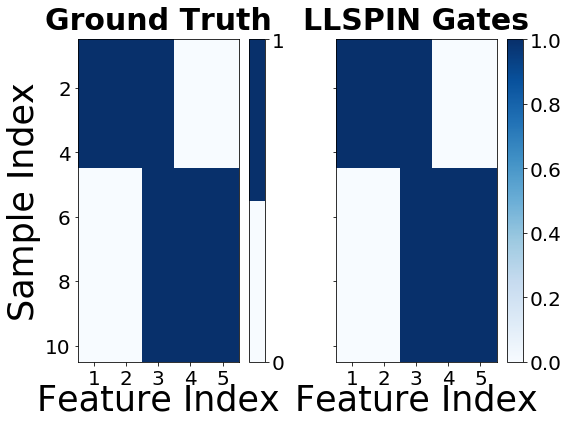

In [23]:
fig, axes = plt.subplots(1, 2,sharex=False, sharey=True,figsize=(8, 6))

sorted_order = np.concatenate((np.where(train_label == 1)[0],np.where(train_label == 2)[0]))

im1 = axes[0].imshow(ref_feat_mat_train[sorted_order,:].astype(int),aspect='auto',cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[0].set_ylabel("Sample Index",fontsize=ylabel_size)
axes[0].set_yticks([1,3,5,7,9])
axes[0].set_yticklabels([2,4,6,8,10],fontsize=ytick_size)
axes[0].set_xticks(list(range(5)))
axes[0].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[0].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)

cbar = fig.colorbar(im1,ax=axes[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

im2 = axes[1].imshow(gate_mat_train[sorted_order,:],aspect='auto',cmap=cmap)
axes[1].set_title("LLSPIN Gates",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[1].set_yticks([1,3,5,7,9])
axes[1].set_yticklabels([2,4,6,8,10],fontsize=ytick_size)
axes[1].set_xticks(list(range(5)))
axes[1].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[1].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)

cbar = fig.colorbar(im2,ax=axes[1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

plt.tight_layout()

### Comparing the test gates to the ground truth

In [24]:
gate_mat_test = best_model.get_prob_alpha(X_test)

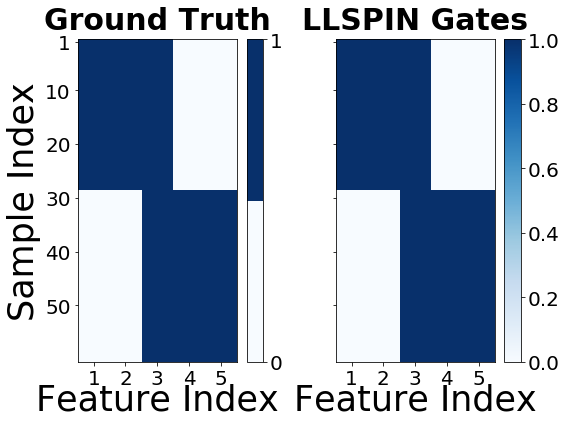

In [25]:
fig, axes = plt.subplots(1, 2,sharex=False, sharey=True,figsize=(8, 6))

fig.subplots_adjust(bottom=0.01)

sorted_order_test = np.concatenate((np.where(test_label == 1)[0],np.where(test_label == 2)[0]))

im1 = axes[0].imshow(ref_feat_mat_test[sorted_order_test,:].astype(int),aspect='auto',cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[0].set_ylabel("Sample Index",fontsize=ylabel_size)
axes[0].set_yticks([0,9,19,29,39,49])
axes[0].set_yticklabels([1,10,20,30,40,50],fontsize=ytick_size)
axes[0].set_xticks(list(range(5)))
axes[0].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[0].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)
cbar = fig.colorbar(im1,ax=axes[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)
    
im2 = axes[1].imshow(gate_mat_test[sorted_order_test,:],aspect='auto',cmap=cmap)
axes[1].set_title("LLSPIN Gates",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[1].set_yticks([0,9,19,29,39,49])
axes[1].set_yticklabels([1,10,20,30,40,50],fontsize=ytick_size)
axes[1].set_xticks(list(range(5)))
axes[1].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[1].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)
    
cbar = fig.colorbar(im2,ax=axes[1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

plt.tight_layout()